In [1]:
# import tensorflow as tf

# # with tf.Session() as sess
# saver = tf.train.Saver()

In [2]:
import numpy as np
import os
import pandas as pd

def find_all(name, path):
    result = []
    for root, dirs, files in os.walk(path):
        if name in files:
            result.append(os.path.join(root, name))
    return result

allpaths = find_all(name='fNIR_data.txt', path='/home/arasdar/datasets/fNIRs_data/')

# df: data frame object
df = []
for each_idx in range(len(allpaths)):
    df.append(pd.read_csv(filepath_or_buffer=allpaths[each_idx], names=['time', 'sample', 
                       'channel', 'channel', 'channel', 'channel', 'channel',
                       'channel', 'channel', 'channel', 'channel', 'channel',
                       'channel', 'channel', 'channel', 'channel', 'channel',
                       'channel', 'channel', 'channel', 'channel', 'channel',
                       'channel', 'channel', 'channel', 'channel', 'channel',
                       'channel', 'channel', 'channel', 'channel', 'channel',
                       'channel', 'channel', 'channel', 'channel', 'channel',
                       'channel', 'channel', 'channel', 'channel', 'channel']))

for each in range(len(df)):
    df[each]['sample'][1:] = df[each]['sample'][1:].astype(str).str[2:]
    df[each]['channel.39'][1:] = df[each]['channel.39'][1:].astype(str).str[1:-1]
    
matrices = []
for each in range(len(df)):
    matrices.append(df[each][1:].as_matrix().astype(float))

data = []
for mat in matrices:
#     print(mat[:, 2:].shape, mat[:, 2:].dtype)
    data.append(mat[:, 2:])

X = data[0] # initialize the stack
X.shape, X.dtype
for each in range(1, len(data), 1): # start, stop, step
    X = np.vstack(tup=(X, data[each]))
    
Xnorm = (X - X.mean(axis=0))/ X.std(axis=0)
# print('Xnorm.shape, Xnorm.dtype, Xnorm.mean(axis=0), Xnorm.std(axis=0):', 
#      Xnorm.shape, Xnorm.dtype, Xnorm.mean(axis=0), Xnorm.std(axis=0))

/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.6/site-packages/pandas/io/parsers.py:709: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)
/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
# sr = 0.129 # 111933.573-111933.504 is the difference between each two samples or sampling rate
# each_trial=30 # 30seconds=20sec+10sec
# width = np.ceil(30/0.129)
# num_mb = mat.shape[0] - width +1
width, l, h, Xnt, Xnv = 250, 0, 0, [], []
for idx in range(0, len(data), 1): # start, stop, step
    l = h
    h += data[idx].shape[0]
    #     print(idx, l, h, h-width, Xnorm.shape, data[idx].shape, Xnorm[l:h].shape, width)
    Xnt.append(Xnorm[l:h-width])
    Xnv.append(Xnorm[h-width:h])
#     print(Xnt[idx].shape, Xnv[idx].shape, data[idx].shape, width)    
#     print(Xnt[idx].dtype, Xnv[idx].dtype, data[idx].dtype, width)
    
mb = []
stride = 50
for eachXnt in range(len(Xnt)):
    num_mb = ((Xnt[eachXnt].shape[0]-width)//stride) + 1
    # each step = (num_mb-1)*stride
    for each in range(num_mb):
        each *= stride
        mb.append(Xnt[eachXnt][each:each+width, :])

Xnt_mb = mb
print('len(Xnt), len(Xnt_mb), len(Xnv):', len(Xnt), len(Xnt_mb), len(Xnv))
print('Xnv[0].shape, Xnt_mb[0].shape:', Xnv[0].shape, Xnt_mb[0].shape)
print('Xnv[0].dtype, Xnt_mb[0].dtype:', Xnv[0].dtype, Xnt_mb[0].dtype)
# # len(mb)
# for eachXnv, eachXnt in zip(Xnv, Xnt):
#     print(eachXnv.shape, eachXnt.shape, eachXnv.dtype, eachXnt.dtype)

len(Xnt), len(Xnt_mb), len(Xnv): 44 2246 44
Xnv[0].shape, Xnt_mb[0].shape: (250, 40) (250, 40)
Xnv[0].dtype, Xnt_mb[0].dtype: float64 float64


In [4]:
## Hyperparameters
# Input data
# NWC for signal: N is batch size, W is the width/sequence length, and C is the number of channels
# NHWC for images: This is the same as signals and H stands for height
N, W, C = len(Xnt_mb)//100, Xnt_mb[0].shape[0], Xnt_mb[0].shape[1]
print('N, W, C', N, W, C)
batch_size, seq_len, n_channels = N, W, C
print('batch_size, seq_len, n_channels', batch_size, seq_len, n_channels)

N, W, C 22 250 40
batch_size, seq_len, n_channels 22 250 40


In [5]:
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


In [6]:
# Input and output and hyperpaprameters NP tensors to feed into TF tensors: NP2TF tensors for computation
# Input and output and hyperpaprameters tensors to feed into the tensor flow framwork
Xin = tf.placeholder(dtype=tf.float32, shape=[None, seq_len, n_channels], name=None)
keep_prob_= tf.placeholder(dtype=tf.float32, name=None, shape=None)
learning_rate_ = tf.placeholder(dtype=tf.float32, name=None, shape=None)

In [7]:
print(Xin.shape, Xin.dtype)
# shape = [kernel_width, input_depth, output_depth] 
W, Cin, Cout = Xin.shape[1].value//4, Xin.shape[2].value, Xin.shape[2].value*2
shape = [W, Cin, Cout]
init_val = tf.random_normal(dtype=tf.float32, mean=0.0, name=None, shape=shape, stddev=1.0)
W1 = tf.Variable(dtype=tf.float32, initial_value=init_val, name=None, trainable=True)
print(W1.shape, W1.dtype)
Xconv1 = tf.nn.conv1d(data_format='NWC', filters=W1, name=None, padding='SAME', stride=2, use_cudnn_on_gpu=True, 
                     value=Xin)
Xconv1 = tf.nn.relu(features=Xconv1, name=None)
print(Xconv1.shape, Xconv1.dtype)

(?, 250, 40) <dtype: 'float32'>
(62, 40, 80) <dtype: 'float32_ref'>
(?, 125, 80) <dtype: 'float32'>


In [8]:
print(Xconv1.shape, Xconv1.dtype)
W, Cin, Cout = Xconv1.shape[1].value//4, Xconv1.shape[2].value, Xconv1.shape[2].value*2
shape = [W, Cin, Cout]
init_val = tf.random_normal(dtype=tf.float32, mean=0.0, name=None, shape=shape, stddev=1.0)
W2 = tf.Variable(dtype=tf.float32, initial_value=init_val, name=None, trainable=True)
print(W2.shape, W2.dtype)
Xconv2 = tf.nn.conv1d(data_format='NWC', filters=W2, name=None, padding='SAME', stride=2, use_cudnn_on_gpu=True, 
                     value=Xconv1)
Xconv2 = tf.nn.relu(features=Xconv2, name=None)
print(Xconv2.shape, Xconv2.dtype)

(?, 125, 80) <dtype: 'float32'>
(31, 80, 160) <dtype: 'float32_ref'>
(?, 63, 160) <dtype: 'float32'>


In [9]:
print(Xconv2.shape, Xconv2.dtype)
W, Cin, Cout = Xconv2.shape[1].value//4, Xconv2.shape[2].value, Xconv2.shape[2].value*2
shape = [W, Cin, Cout]
init_val = tf.random_normal(dtype=tf.float32, mean=0.0, name=None, shape=shape, stddev=1.0)
W3 = tf.Variable(dtype=tf.float32, initial_value=init_val, name=None, trainable=True)
print(W3.shape, W3.dtype)
Xconv3 = tf.nn.conv1d(data_format='NWC', filters=W3, name=None, padding='SAME', stride=2, use_cudnn_on_gpu=True, 
                     value=Xconv2)
Xconv3 = tf.nn.relu(features=Xconv3, name=None)
print(Xconv3.shape, Xconv3.dtype)

(?, 63, 160) <dtype: 'float32'>
(15, 160, 320) <dtype: 'float32_ref'>
(?, 32, 320) <dtype: 'float32'>


In [10]:
print(Xconv3.shape, Xconv3.dtype)
W, Cin, Cout = Xconv2.shape[1].value//4, Xconv2.shape[2].value, Xconv2.shape[2].value*2
shape = [W, Cin, Cout]
init_val = tf.random_normal(dtype=tf.float32, mean=0., name=None, shape=shape, stddev=1.0)
W3T = tf.Variable(dtype=tf.float32, initial_value=init_val, name=None, trainable=False)
print(W3T.shape, W3T.dtype)
# output shape should be NWC equal to Xconv2
out_shape = [batch_size, Xconv2.shape[1].value, Xconv2.shape[2].value] # NWC, only N should be set (experimental)
print(out_shape)
Xconv2_ = tf.contrib.nn.conv1d_transpose(data_format='NWC', filter=W3T, name=None, padding='SAME', stride=2, 
                                         value=Xconv3, output_shape=out_shape)
Xconv2_ = tf.nn.relu(features=Xconv2_, name=None)
print(Xconv2_.shape, Xconv2_.dtype)
print(Xconv2.shape, Xconv2.dtype)

(?, 32, 320) <dtype: 'float32'>
(15, 160, 320) <dtype: 'float32_ref'>
[22, 63, 160]
Instructions for updating:
Use the retry module or similar alternatives.
(22, 63, 160) <dtype: 'float32'>
(?, 63, 160) <dtype: 'float32'>


In [11]:
print(Xconv2_.shape, Xconv2_.dtype)
W, Cin, Cout = Xconv1.shape[1].value//4, Xconv1.shape[2].value, Xconv1.shape[2].value*2
shape = [W, Cin, Cout]
init_val = tf.random_normal(dtype=tf.float32, mean=0., name=None, shape=shape, stddev=1.0)
W2T = tf.Variable(dtype=tf.float32, initial_value=init_val, name=None, trainable=False)
print(W2T.shape, W2T.dtype)
# output shape should be NWC equal to Xconv1
out_shape = [batch_size, Xconv1.shape[1].value, Xconv1.shape[2].value] # NWC, only N should be set (experimental)
print(out_shape)
Xconv1_ = tf.contrib.nn.conv1d_transpose(data_format='NWC', filter=W2T, name=None, padding='SAME', stride=2, 
                                         value=Xconv2_, output_shape=out_shape)
Xconv1_ = tf.nn.relu(features=Xconv1_, name=None)
print(Xconv1_.shape, Xconv1_.dtype)
print(Xconv1.shape, Xconv1.dtype)

(22, 63, 160) <dtype: 'float32'>
(31, 80, 160) <dtype: 'float32_ref'>
[22, 125, 80]
(22, 125, 80) <dtype: 'float32'>
(?, 125, 80) <dtype: 'float32'>


In [12]:
print(Xconv1_.shape, Xconv1_.dtype)
W, Cin, Cout = Xin.shape[1].value//4, Xin.shape[2].value, Xin.shape[2].value*2 
shape = [W, Cin, Cout]
init_val = tf.random_normal(dtype=tf.float32, mean=0., name=None, shape=shape, stddev=1.0)
W1T = tf.Variable(dtype=tf.float32, initial_value=init_val, name=None, trainable=False)
print(W1T.shape, W1T.dtype)
# output shape should be NWC equal to Xin
out_shape = [batch_size, Xin.shape[1].value, Xin.shape[2].value] # NWC, only N should be set (experimental)
print(out_shape)
Xout = tf.contrib.nn.conv1d_transpose(data_format='NWC', filter=W1T, name=None, padding='SAME', stride=2, 
                                         value=Xconv1_, output_shape=out_shape)
# Xin_ = tf.nn.relu(features=Xin_, name=None)
Xout_prob = tf.nn.sigmoid(name=None, x=Xout)
print(Xout.shape, Xout.dtype)
print(Xout_prob.shape, Xout_prob.dtype)
print(Xin.shape, Xin.dtype)

(22, 125, 80) <dtype: 'float32'>
(62, 40, 80) <dtype: 'float32_ref'>
[22, 250, 40]
(22, 250, 40) <dtype: 'float32'>
(22, 250, 40) <dtype: 'float32'>
(?, 250, 40) <dtype: 'float32'>


In [13]:
# Backward pass: error backpropagation
# Cost function
# cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost_tensor = tf.nn.sigmoid_cross_entropy_with_logits(labels=Xin, logits=Xout, name=None)
print(cost_tensor.shape, cost_tensor.dtype)
cost = tf.reduce_mean(input_tensor=cost_tensor)
# The cost has to be positive since it is a distance between two vectors in the hyperspace
# Eucleadian dist or length, angle or entropy are all these kinds of distance
cost = tf.abs(name=None, x=cost)
print(cost.shape, cost.dtype)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)
print('optimizer', optimizer)

(22, 250, 40) <dtype: 'float32'>
() <dtype: 'float32'>
optimizer name: "Adam"
op: "NoOp"
input: "^Adam/update_Variable/ApplyAdam"
input: "^Adam/update_Variable_1/ApplyAdam"
input: "^Adam/update_Variable_2/ApplyAdam"
input: "^Adam/Assign"
input: "^Adam/Assign_1"



In [14]:
def get_batches(X, batch_size):
    """ Return a generator for batches """
    n_batches = len(X) // batch_size
    X = X[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size]

In [15]:
# # get_batches(X=Xnt_mb, batch_size=batch_size)
# # Loop over batches
# for each in get_batches(X=Xnt_mb, batch_size=batch_size):
#     print(len(each), each[0].shape, each[0].dtype)

In [16]:
print('len(Xnv):', len(Xnv))
for each in get_batches(X=Xnv, batch_size=batch_size):
    print(len(each), each[0].shape, each[0].dtype)

len(Xnv): 44
22 (250, 40) float64
22 (250, 40) float64


In [19]:
## Hyperparameters
# learning parameters
# Let's reduce the number of hyperparameters
# X input shape=NCW
learning_rate = 1e-3 # 0.001
keep_prob = 1.0 # 90% neurons are kept and 10% are dropped out
epochs = 100 # num iterations for updating model

# Save the training result or trained and validated model params
saver = tf.train.Saver()
train_loss, valid_loss = [], []

In [ ]:
with tf.Session() as sess:
    # my assumption is the local variables are the parameters and hyperparameters
    # the globala variables are the one needed/required by the seession/graph to run
    sess.run(fetches=tf.global_variables_initializer())
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for X_train_norm_batch in get_batches(X=Xnt_mb, batch_size=batch_size):
            
            ######################## Training
            # Feed dictionary
            feed = {Xin : X_train_norm_batch, keep_prob_ : keep_prob, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ = sess.run(fetches=[cost, optimizer], feed_dict = feed)
            train_loss.append(loss)

            ################## Validation
            loss_batch = []    
            # Loop over batches
            for X_valid_norm_batch in get_batches(X=Xnv, batch_size=batch_size):
            
                # Feed dictionary
                feed = {Xin : X_valid_norm_batch, keep_prob_ : 1.0} 
                # no learning is needed therefore no learning rate is needed.

                # Loss
                loss = sess.run(fetches=[cost], feed_dict = feed)
                # no learning is needed therefore no learning rate is needed.
                # Therefore no optimization approach or backprop is needed either.
                loss_batch.append(loss)

            # Store
            valid_loss.append(np.mean(loss_batch))
            
        # Print info for every iter/epoch
        print("Epoch: {}/{}".format(e+1, epochs),
              "Train loss: {:6f}".format(np.mean(train_loss)),
              "Valid loss: {:.6f}".format(np.mean(valid_loss)))
    
    # At the end of training and validation
#     saver.save(sess,"./checkpoints2/cnn-fnirs-autoencoder.ckpt")
    saver.save(save_path='checkpoints-latest/model.ckpt', sess=sess)

Epoch: 1/100 Train loss: 363699488.000000 Valid loss: 380558784.000000
Epoch: 2/100 Train loss: 242946448.000000 Valid loss: 254348192.000000
Epoch: 3/100 Train loss: 185192240.000000 Valid loss: 195763520.000000
Epoch: 4/100 Train loss: 151538784.000000 Valid loss: 163140656.000000
Epoch: 5/100 Train loss: 130053752.000000 Valid loss: 142683552.000000
Epoch: 6/100 Train loss: 115720624.000000 Valid loss: 129593880.000000
Epoch: 7/100 Train loss: 104304648.000000 Valid loss: 118758368.000000
Epoch: 8/100 Train loss: 95083544.000000 Valid loss: 108748040.000000
Epoch: 9/100 Train loss: 87428184.000000 Valid loss: 100579984.000000
Epoch: 10/100 Train loss: 81094328.000000 Valid loss: 93738376.000000
Epoch: 11/100 Train loss: 75772760.000000 Valid loss: 88149008.000000
Epoch: 12/100 Train loss: 71323360.000000 Valid loss: 83025144.000000
Epoch: 13/100 Train loss: 67167032.000000 Valid loss: 78315144.000000
Epoch: 14/100 Train loss: 63506012.000000 Valid loss: 74335032.000000
Epoch: 15/100

In [ ]:
import matplotlib.pyplot as mplot
%matplotlib inline

mplot.plot(train_loss, label='har train_loss')
mplot.plot(valid_loss, label='har valid_loss')
mplot.legend()
mplot.show()

In [22]:
# # initilize the saver which has already been initialized.
# test_loss = []

# with tf.Session() as sess:
#     # Restore the validated model
#     saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
#     ################## Test
#     loss_batch = []    
#     # Loop over batches
#     for X_test_norm_batch, _ in get_batches(X_test_norm, Y_test_onehot, batch_size):

#         # Feed dictionary
#         # No learning/training is needed at this step
#         feed = {Xin: X_test_norm_batch, keep_prob_ : 1.0}

#         # Loss
#         # Only the computation of the cost is needed
#         loss = sess.run(fetches=[cost], feed_dict = feed)
#         loss_batch.append(loss)

#     # Store
#     test_loss.append(np.mean(loss_batch))

#     # Print info for every iter/epoch
#     print("Test loss: {:6f}".format(np.mean(test_loss)))

In [23]:
# # import the inspect_checkpoint library
# from tensorflow.python.tools import inspect_checkpoint as chkp

# # print all tensors in checkpoint file
# chkp.print_tensors_in_checkpoint_file(file_name='checkpoints/cnn-fnirs-autoencoder.ckpt', tensor_name='', 
#                                       all_tensors=False, 
#                                       all_tensor_names='')

# # # tensor_name:  v1
# # # [ 1.  1.  1.]
# # # tensor_name:  v2
# # # [-1. -1. -1. -1. -1.]

# # # print only tensor v1 in checkpoint file
# # chkp.print_tensors_in_checkpoint_file("./tmp/model.ckpt", tensor_name='v1', all_tensors=False)

# # # tensor_name:  v1
# # # [ 1.  1.  1.]

# # # print only tensor v2 in checkpoint file
# # chkp.print_tensors_in_checkpoint_file("./tmp/model.ckpt", tensor_name='v2', all_tensors=False)

# # # tensor_name:  v2
# # # [-1. -1. -1. -1. -1.]

In [20]:
# from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file

# print_tensors_in_checkpoint_file(tensor_name='', file_name='./checkpoints/cnn-fnirs-autoencoder.ckpt',
#                                  all_tensor_names='', 
#                                  all_tensors=False)

In [23]:
# saver2 = tf.train.Saver()
# with tf.Session() as sess:
#     saver2.restore(save_path='./checkpoints3/model.ckpt', sess=sess)

In [24]:
# # saver.recover_last_checkpoints(checkpoint_paths='./checkpoints/
# # tf.reset_default_graph()
# with tf.Session() as sess:
#     saver.restore(save_path='./checkpoints3/model.ckpt', sess=sess)
# #     saver.restore(save_path='./checkpoints2/cnn-fnirs-autoencoder.ckpt', sess=sess)

In [25]:
# # Create some variables.
# v1 = tf.get_variable("v1", shape=[3], initializer = tf.zeros_initializer)
# v2 = tf.get_variable("v2", shape=[5], initializer = tf.zeros_initializer)

# inc_v1 = v1.assign(v1+1)
# dec_v2 = v2.assign(v2-1)

# # Add an op to initialize the variables.
# init_op = tf.global_variables_initializer()

# # Add ops to save and restore all the variables.
# saver = tf.train.Saver()

# # Later, launch the model, initialize the variables, do some work, and save the
# # variables to disk.
# with tf.Session() as sess:
#   sess.run(init_op)
#   # Do some work with the model.
#   inc_v1.op.run()
#   dec_v2.op.run()
#   # Save the variables to disk.
#   save_path = saver.save(sess, "/tmp/model.ckpt")
#   print("Model saved in path: %s" % save_path)

In [26]:
# # tf.reset_default_graph()

# # # Create some variables.
# # v1 = tf.get_variable("v1", shape=[3])
# # v2 = tf.get_variable("v2", shape=[5])

# # # Add ops to save and restore all the variables.
# # saver = tf.train.Saver()

# # Later, launch the model, use the saver to restore variables from disk, and
# # do some work with the model.
# with tf.Session() as sess:
#   # Restore variables from disk.
#   saver.restore(sess=sess, save_path='/tmp/model.ckpt')
#   print('Model restored.')
#   # Check the values of the variables
#   print("v1 : %s" % v1.eval())
#   print("v2 : %s" % v2.eval())

In [27]:
# # W1.shape, W1.dtype # kWidth, kCHin, kCHout(number of filters) 
# # W1.shape
# # # tf.cast(dtype=tf.int, name=None, x=W1[:, :, 0])
# # # mplot.imshow(W1[:, :, 0])
# # # mplot.i# Before doing anything, I should transfer the tensor/variable data from TF to NP to be able to use matplotlib 
# # # for visualizing mat or np mat
# # # initilize the saver which has already been initialized.
# # # test_loss = []
# # # W1np, W2np, W3np are all needed to be taken out of tensorflow tensors or framework
# # # W1np, W2np, W3np = 
# # # np.array([*W1.shape])

# with tf.Session() as sess:
#     # Restore the validated model
# #     saver.restore(sess=sess, save_path=tf.train.latest_checkpoint('./checkpoints/'))
# #     saver.restore(save_path='./checkpoints2/cnn-fnirs-autoencoder.ckpt', sess=sess)
#     saver.restore(save_path='/tmp/model.ckpt', sess=sess)
# #     print(tf.train.load_variable(ckpt_dir_or_file='checkpoints/cnn-fnirs-autoencoder.ckpt', name=None))
# #     tf.tools.graph_transforms
# #     W1np, W2np, W3np = sess.run(fetches=[W1, W2, W3])

In [28]:
# print('W1np.shape, W1np.dtype, W2np.shape, W2np.dtype, W3np.shape, W3np.dtype:', 
#       W1np.shape, W1np.dtype, W2np.shape, W2np.dtype, W3np.shape, W3np.dtype)
# print('WidthxChinxChout')

In [33]:
ckpt = tf.train.load_checkpoint(ckpt_dir_or_file='./checkpoints/cnn-fnirs-autoencoder.ckpt')
ckpt.get_variable_to_shape_map()
W1np=ckpt.get_tensor('Variable_1/Adam')
W2np=ckpt.get_tensor('Variable_2/Adam')
W3np=ckpt.get_tensor('Variable_3/Adam')

In [34]:
W=W1np
num_filters_1st_layer = W.shape[1]*W.shape[2]
print('num_filters_1st_layer:', num_filters_1st_layer)

num_filters_1st_layer: 3200


In [35]:
W=W2np
num_filters_2nd_layer = W.shape[1]*W.shape[2]
print('num_filters_2nd_layer:', num_filters_2nd_layer)

num_filters_2nd_layer: 12800


In [36]:
W=W3np
num_filters_3rd_layer = W.shape[1]*W.shape[2]
print('num_filters_3rd_layer:', num_filters_3rd_layer)

num_filters_3rd_layer: 51200


In [37]:
# total_num_filters for all three layers
total = num_filters_1st_layer+num_filters_2nd_layer+num_filters_3rd_layer
print('total:', total)

total: 67200


In [38]:
# Wnp = W1np
# mplot.figure(0)
# mplot.plot(Wnp[:, 0, 0])
# mplot.figure(1)
# mplot.plot(Wnp[:, 1, 0])
# mplot.figure(2)
# mplot.plot(Wnp[:, 2, 0])
# mplot.figure(3)
# mplot.plot(Wnp[:, 3, 0])

In [39]:
# Wnp = W2np
# mplot.figure(0)
# mplot.plot(Wnp[:, 0, 0])
# mplot.figure(1)
# mplot.plot(Wnp[:, 1, 0])
# mplot.figure(2)
# mplot.plot(Wnp[:, 2, 0])
# mplot.figure(3)
# mplot.plot(Wnp[:, 3, 0])

In [40]:
# Wnp = W3np
# # mplot.figure(0)
# # mplot.subplot()
# mplot.subplots()
# mplot.plot(Wnp[:, 0, 0])
# mplot.subplots()
# mplot.plot(Wnp[:, 1, 0])
# # mplot.figure(2)
# # mplot.plot(Wnp[:, 2, 0])
# # mplot.figure(3)
# # mplot.plot(Wnp[:, 3, 0])

/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


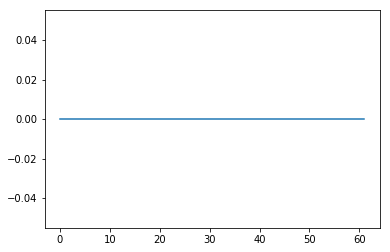

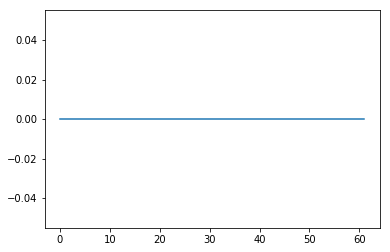

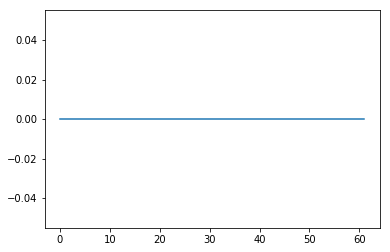

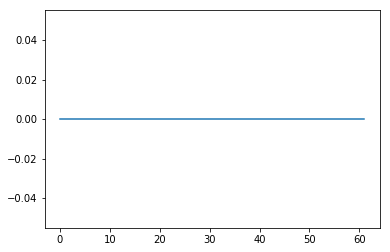

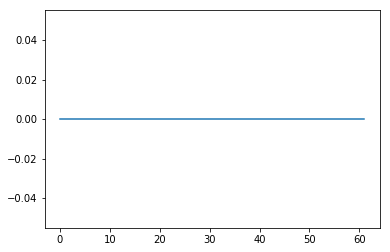

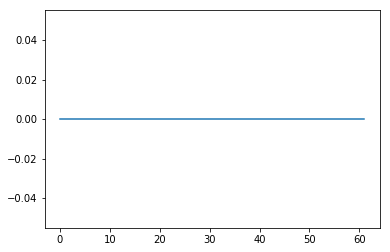

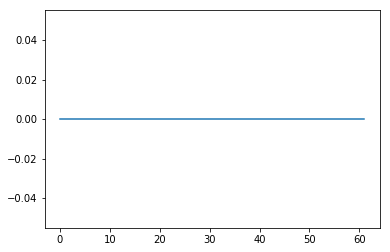

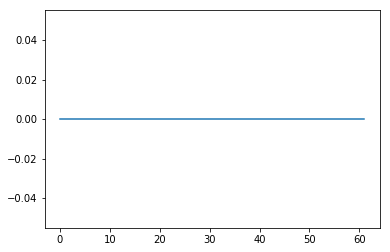

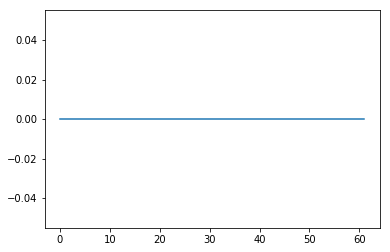

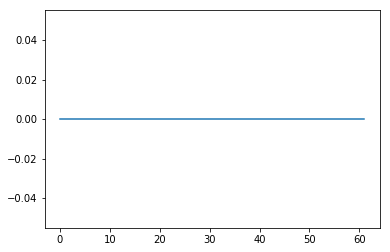

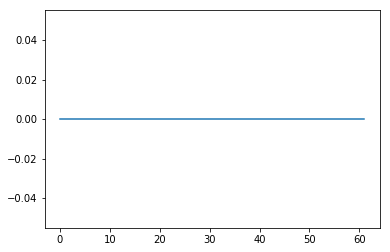

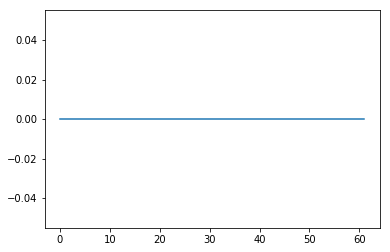

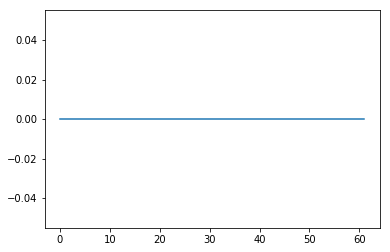

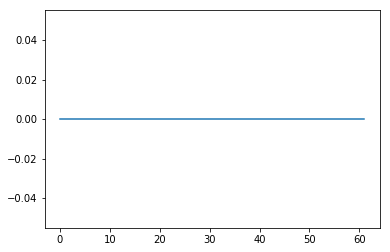

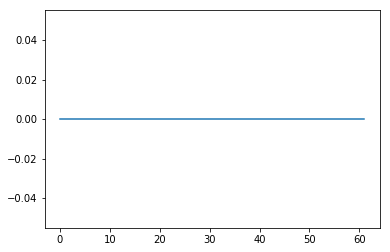

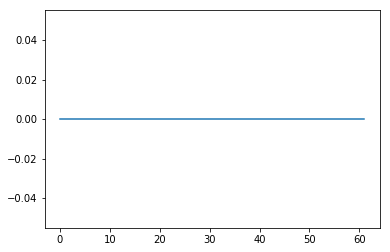

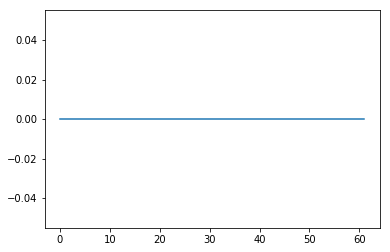

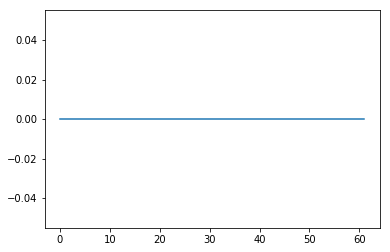

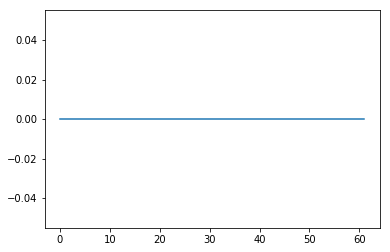

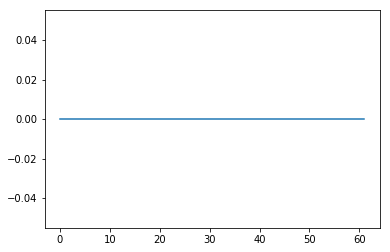

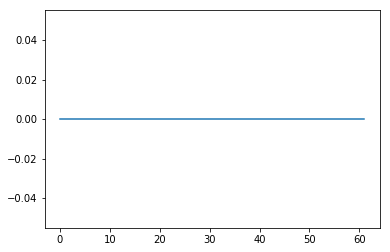

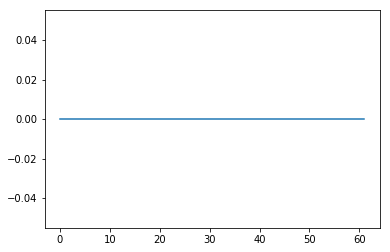

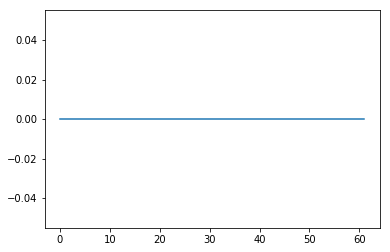

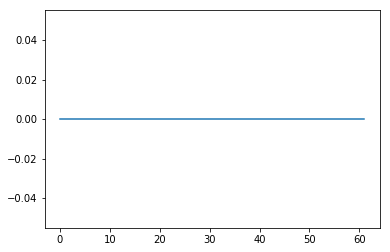

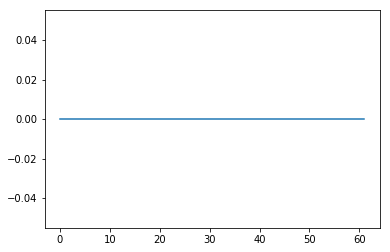

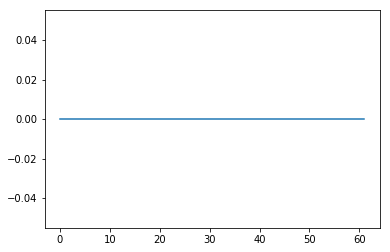

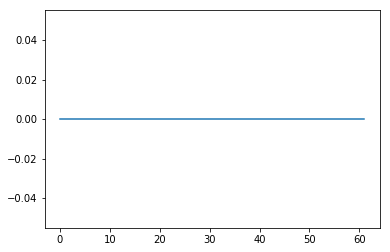

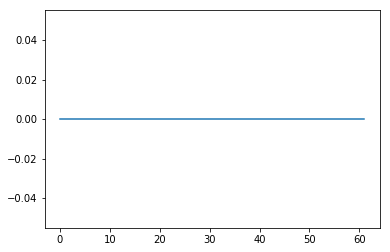

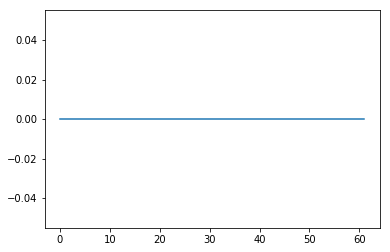

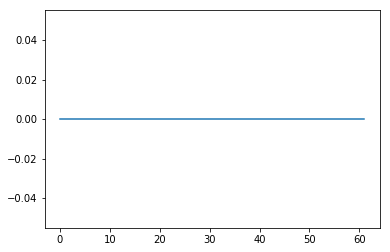

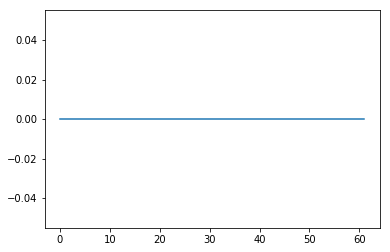

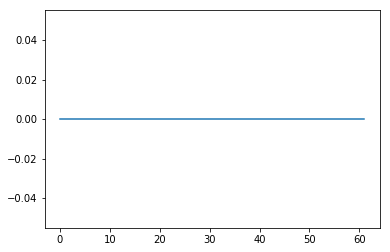

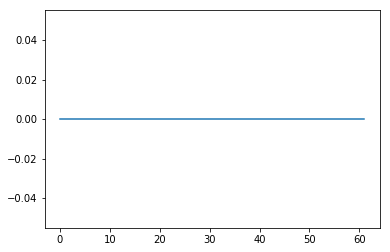

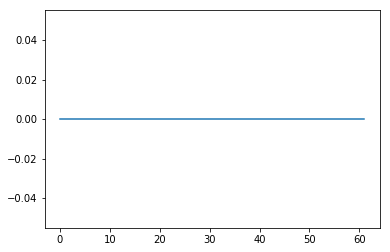

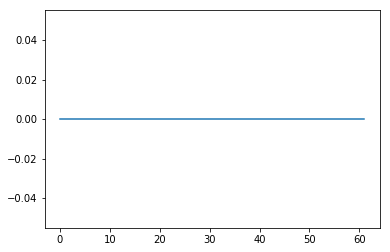

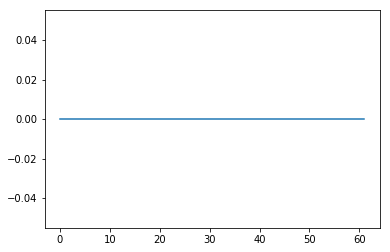

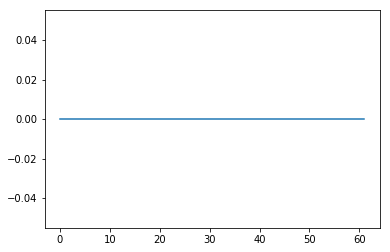

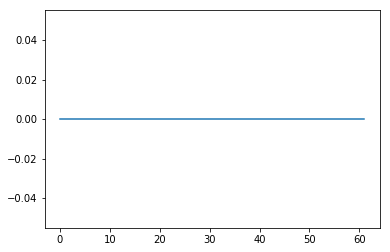

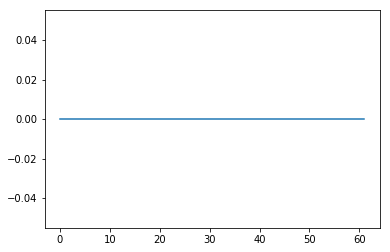

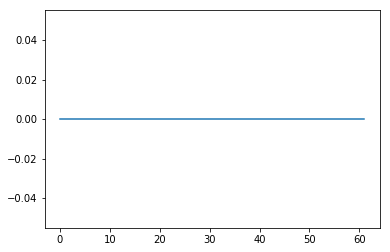

In [42]:
import matplotlib.pyplot as mplot
%matplotlib inline

W = W1np
for each_CHin in range(W.shape[1]):
    each_CHout = 0
#     for each_CHout in range(2):
    mplot.figure(num=(each_CHin + each_CHout))
    mplot.plot(W[:, each_CHin, each_CHout])

/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


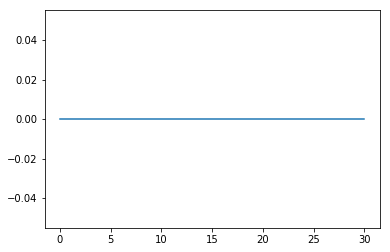

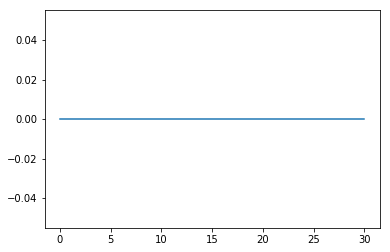

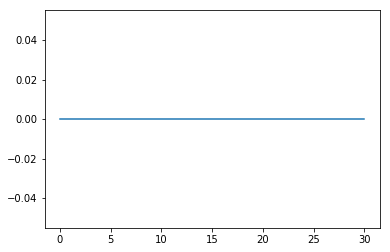

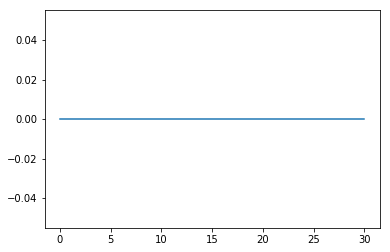

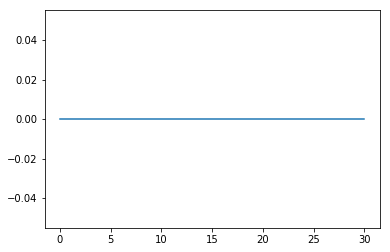

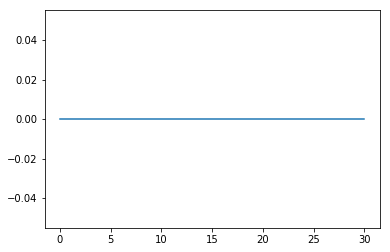

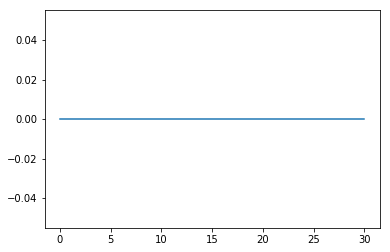

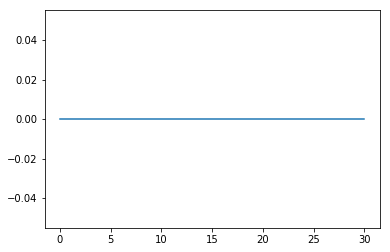

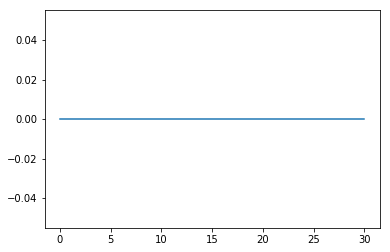

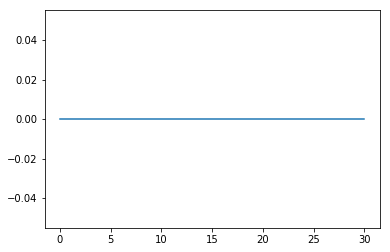

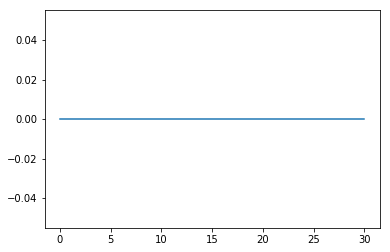

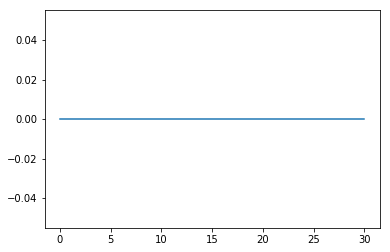

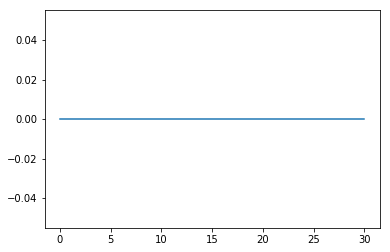

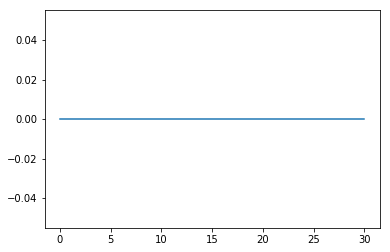

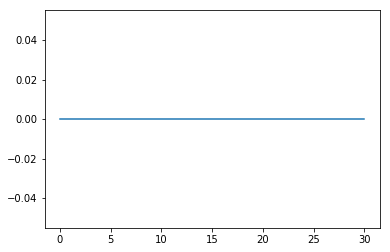

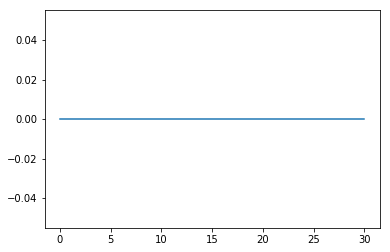

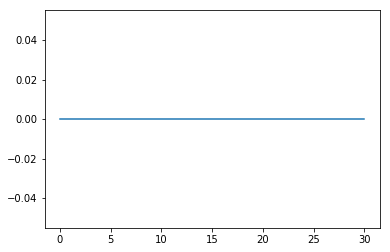

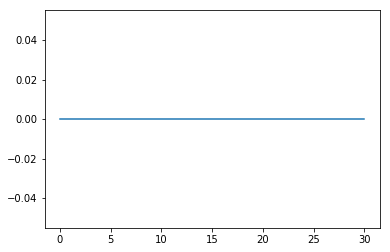

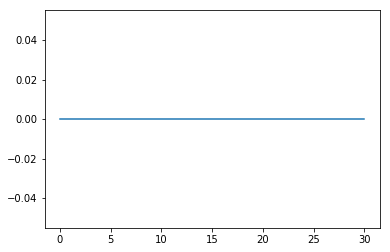

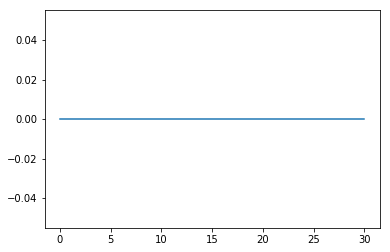

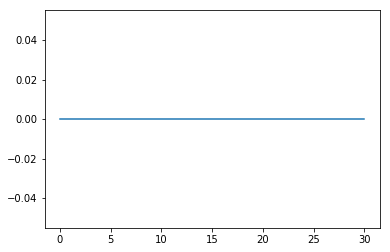

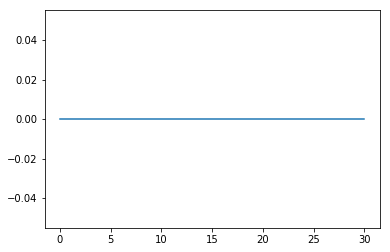

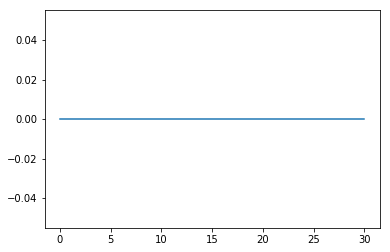

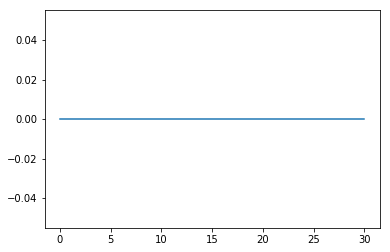

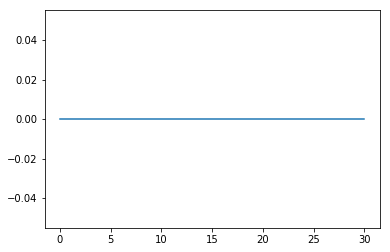

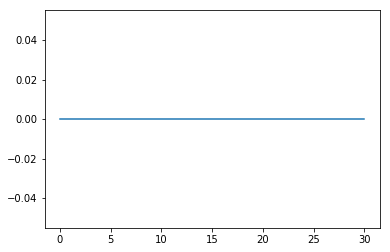

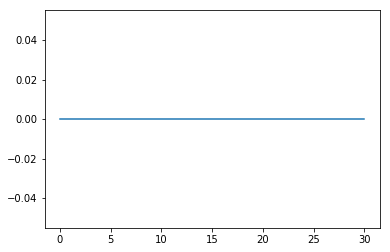

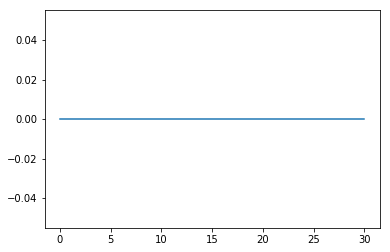

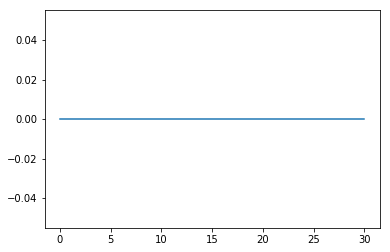

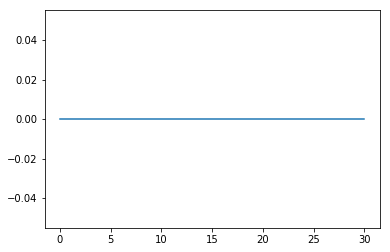

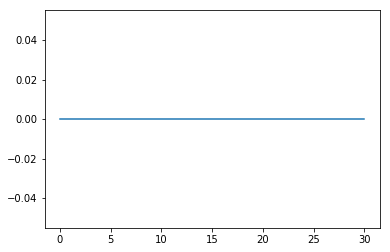

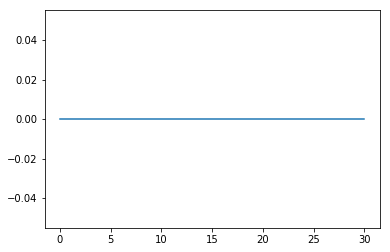

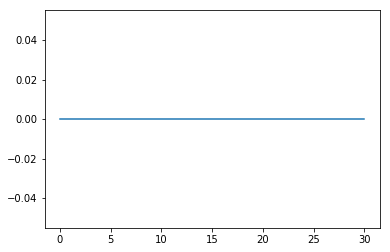

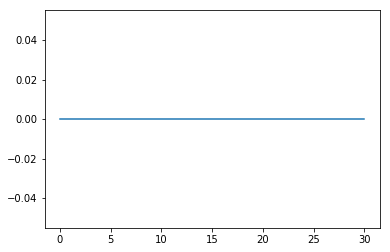

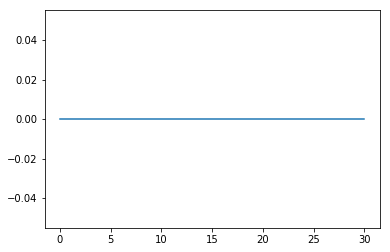

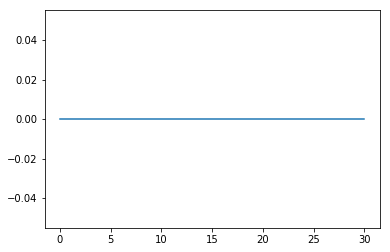

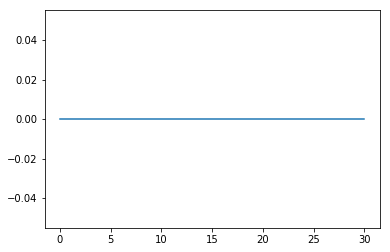

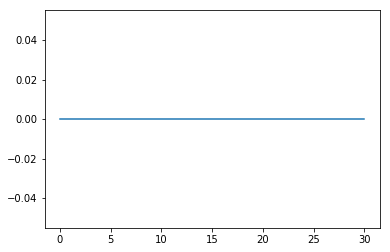

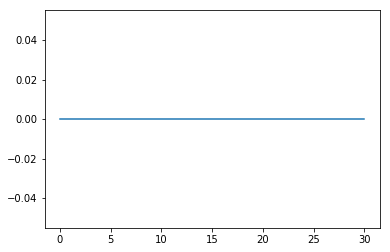

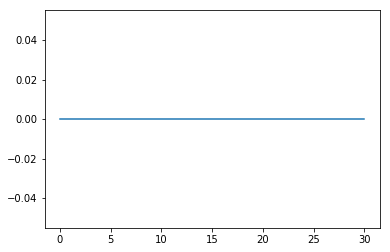

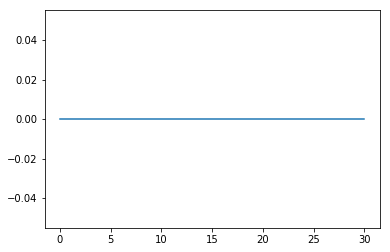

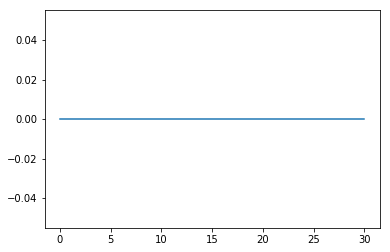

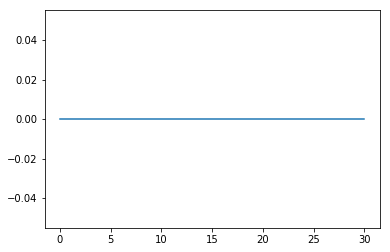

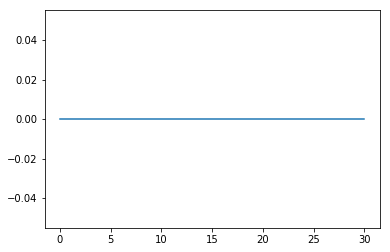

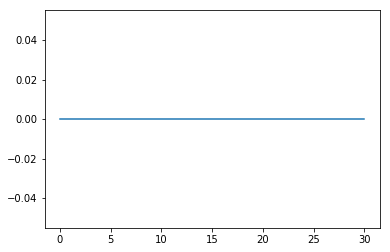

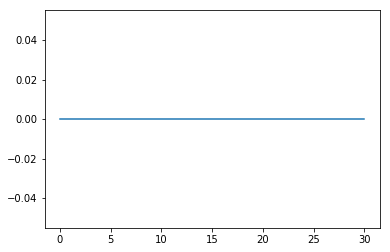

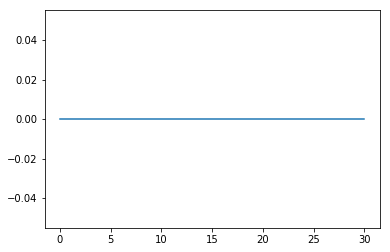

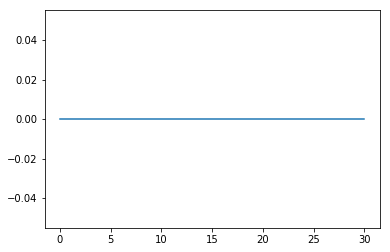

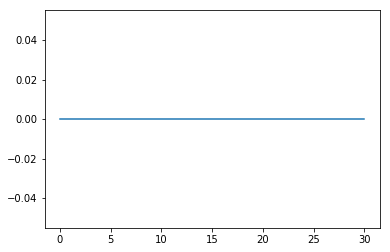

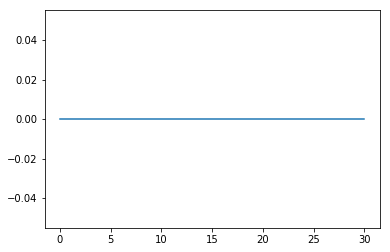

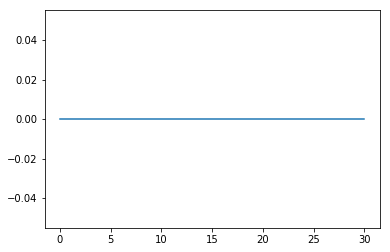

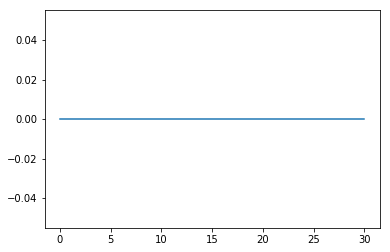

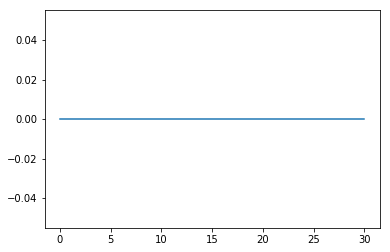

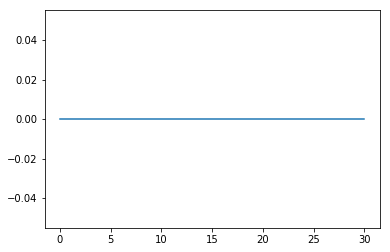

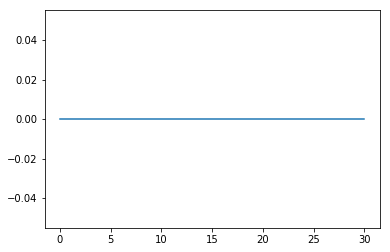

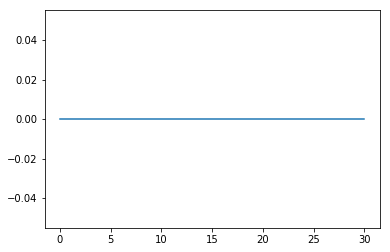

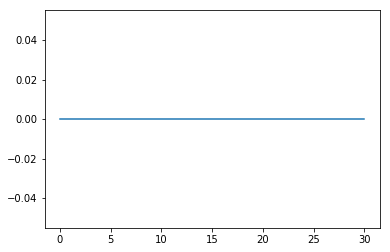

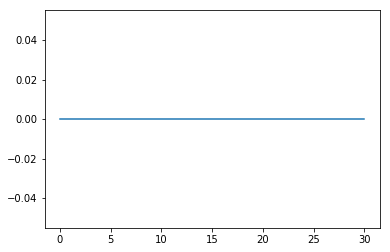

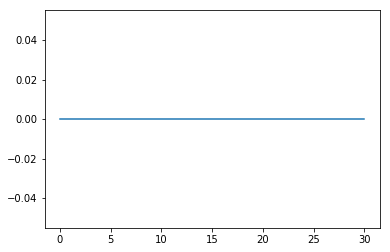

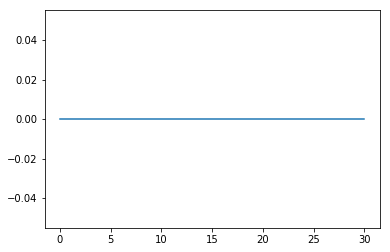

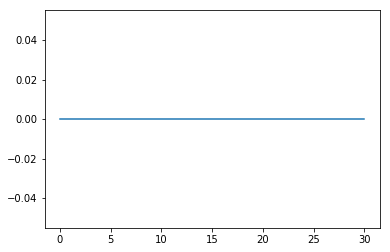

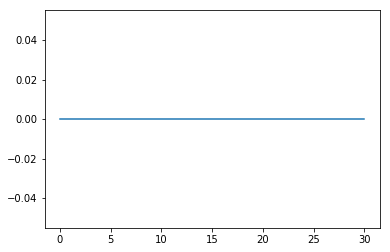

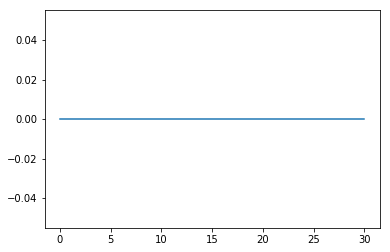

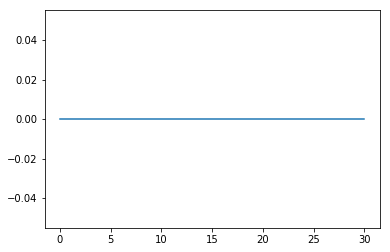

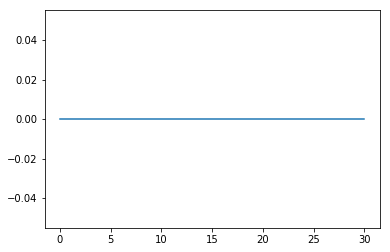

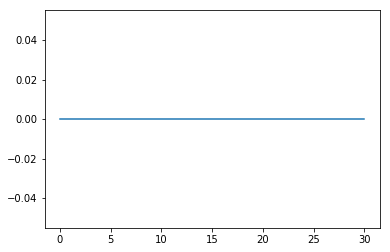

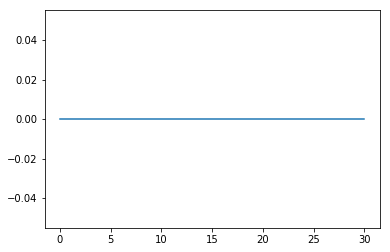

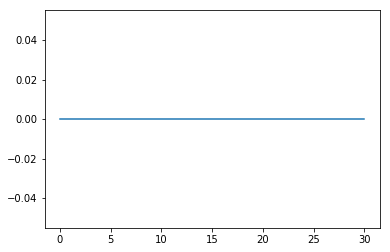

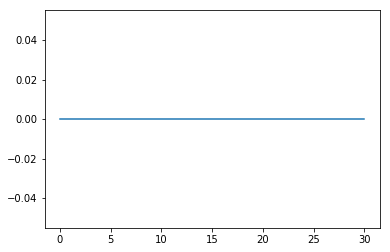

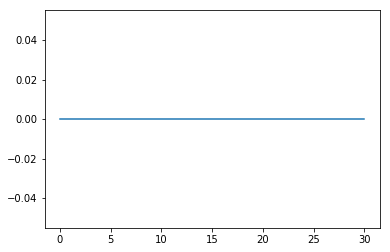

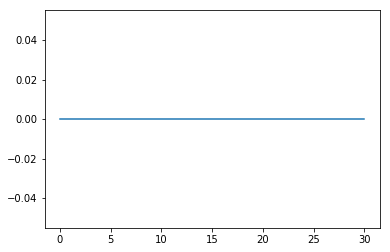

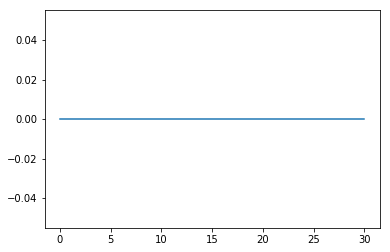

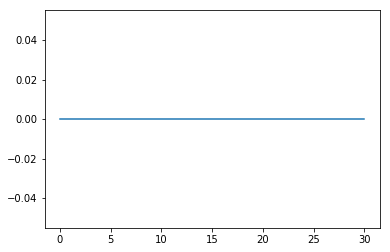

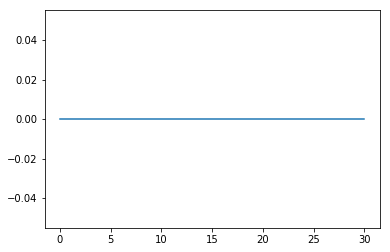

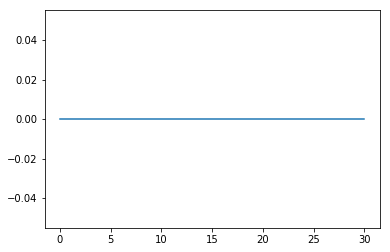

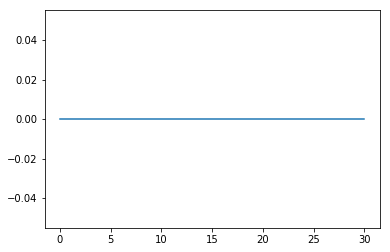

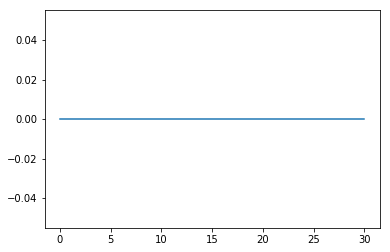

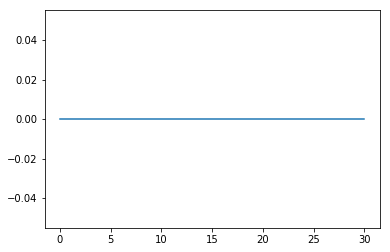

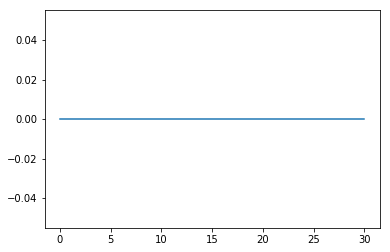

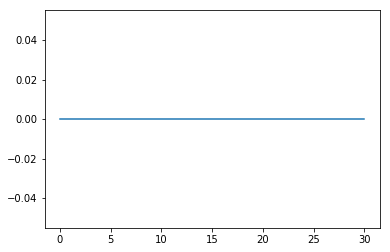

In [43]:
W = W2np
for each_CHin in range(W.shape[1]):
    each_CHout = 0
    # for each_CHout in range(W.shape[2]):
    mplot.figure(each_CHin + each_CHout)
    mplot.plot(W[:, each_CHin, each_CHout])

/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


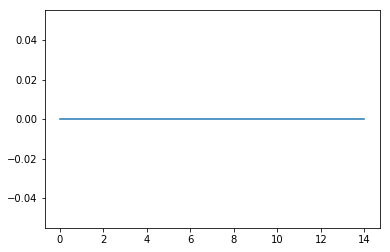

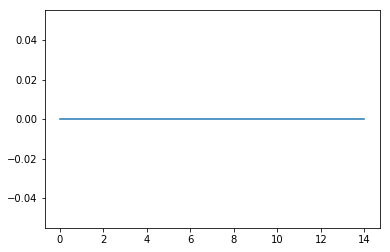

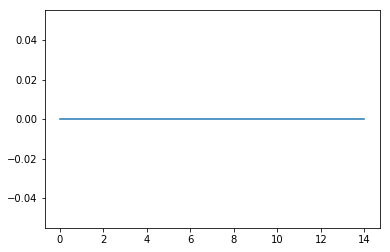

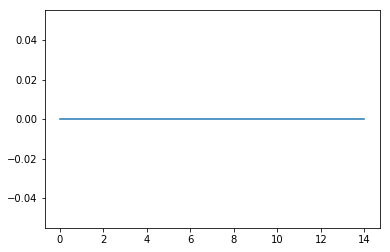

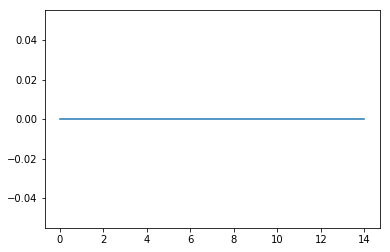

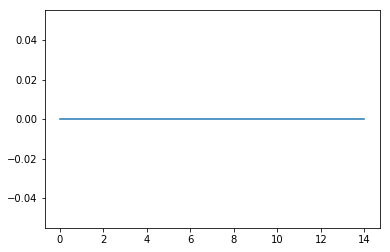

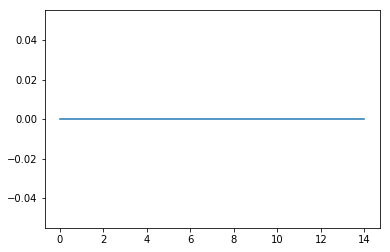

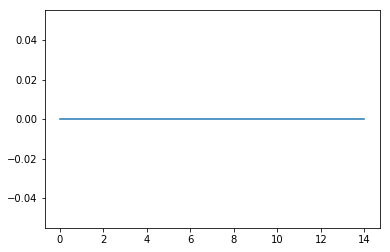

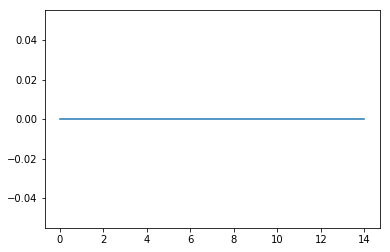

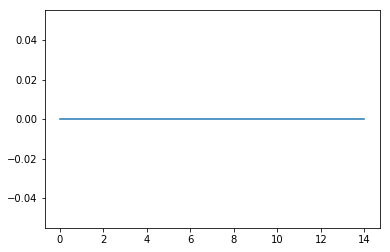

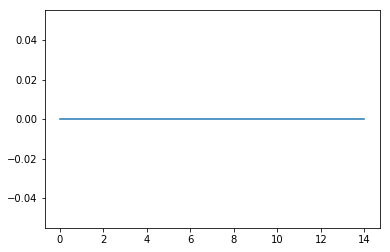

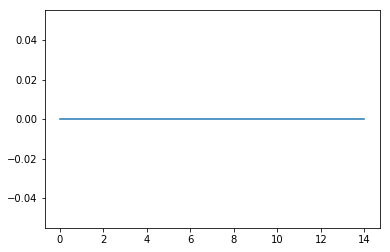

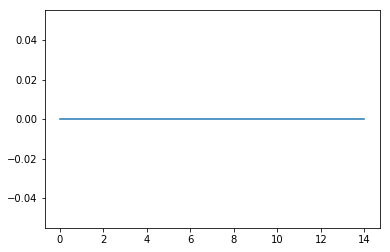

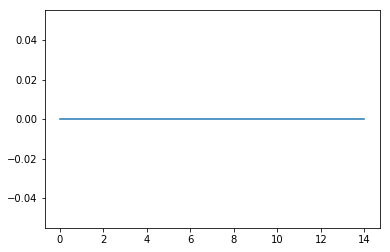

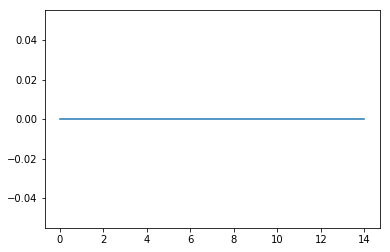

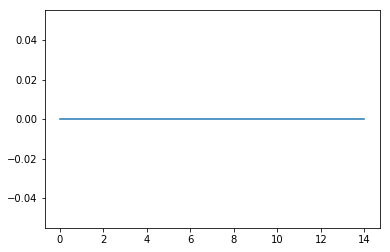

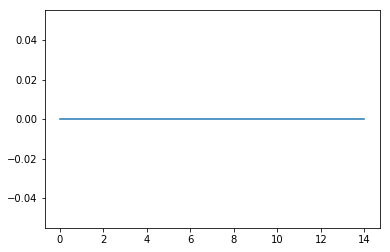

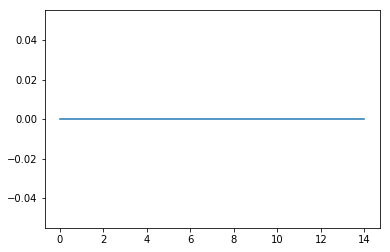

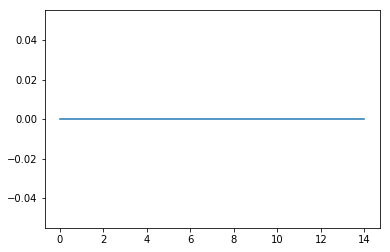

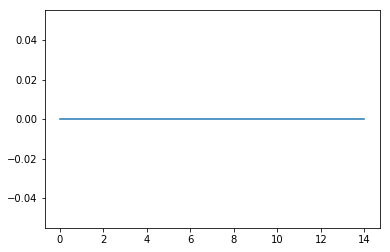

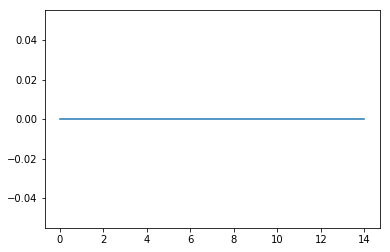

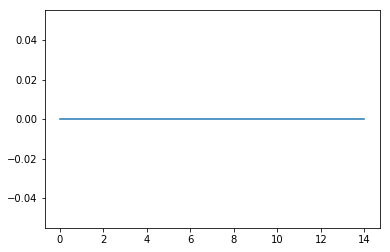

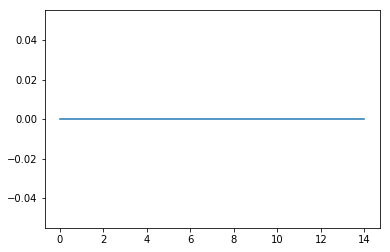

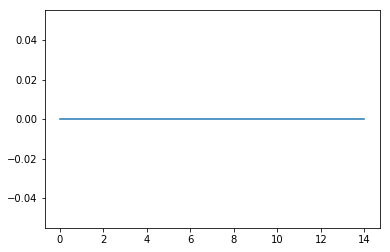

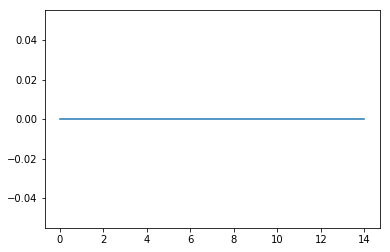

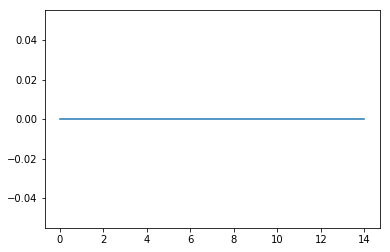

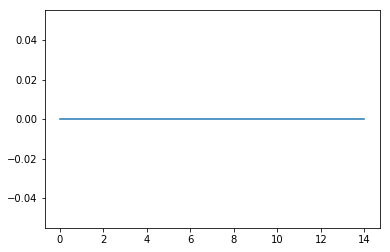

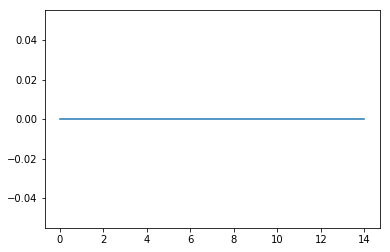

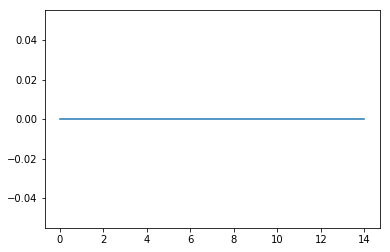

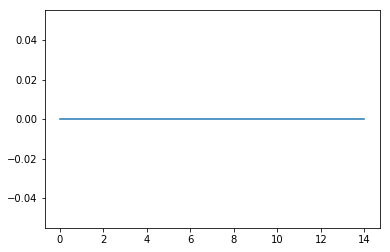

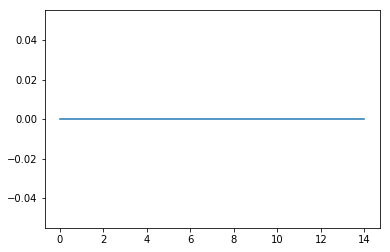

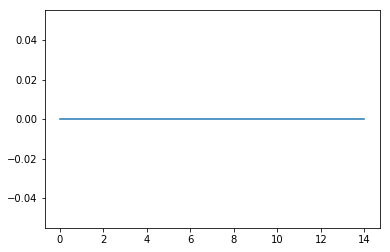

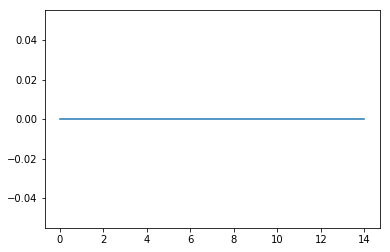

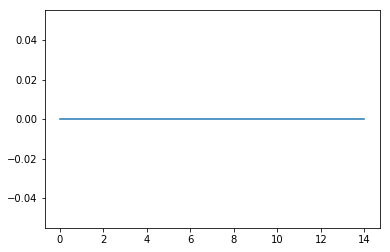

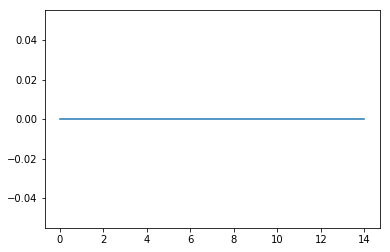

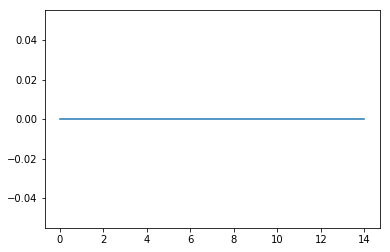

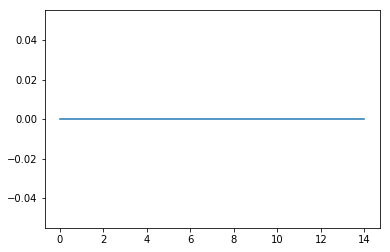

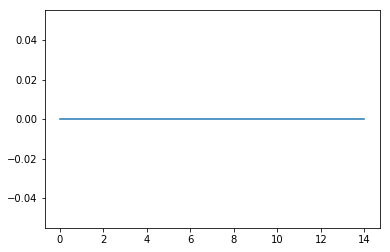

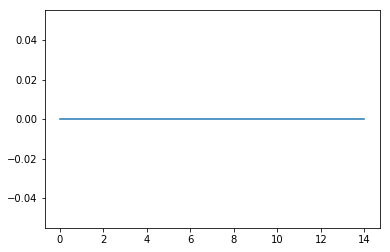

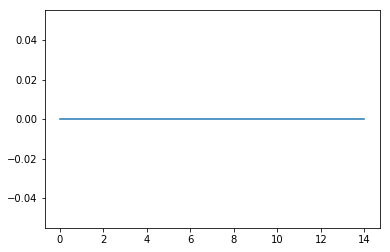

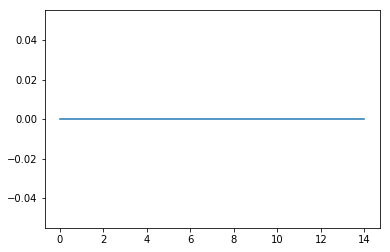

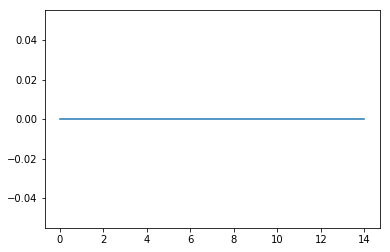

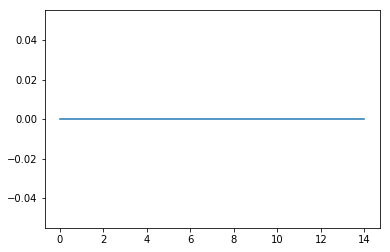

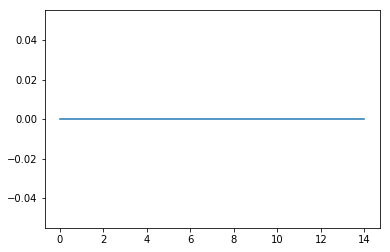

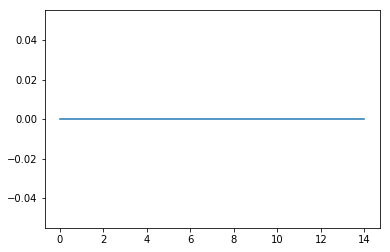

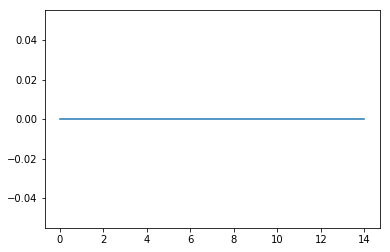

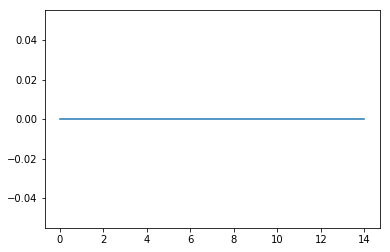

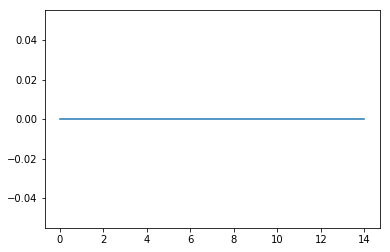

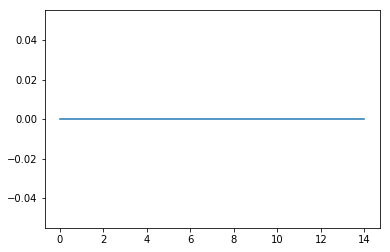

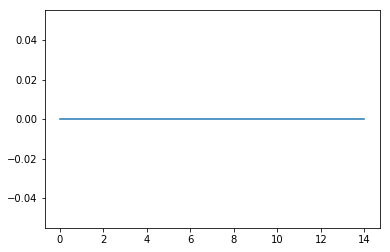

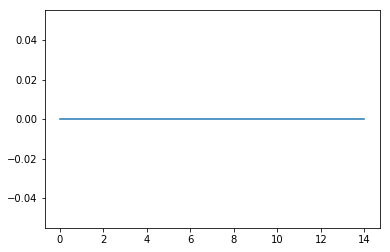

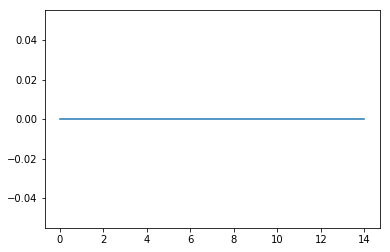

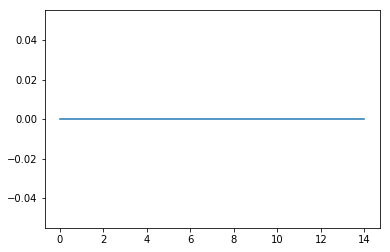

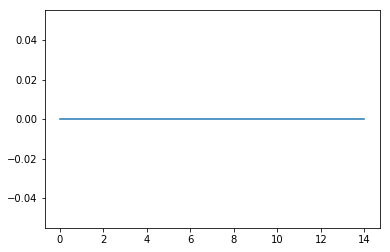

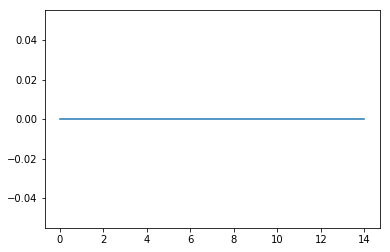

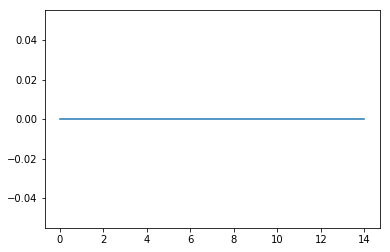

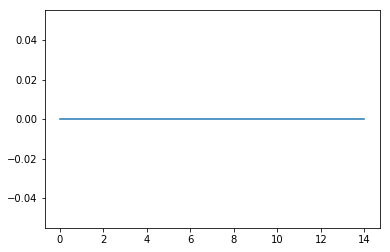

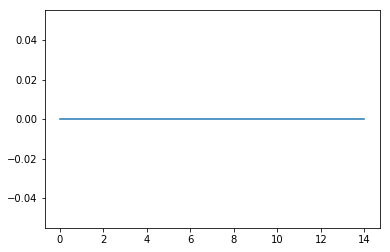

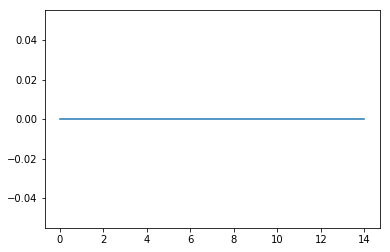

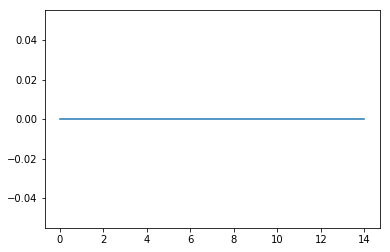

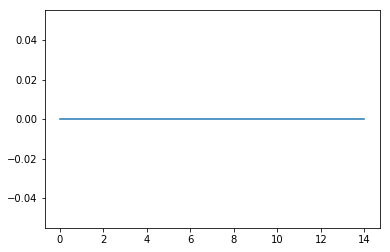

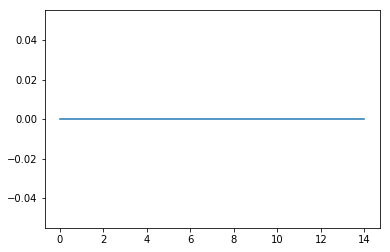

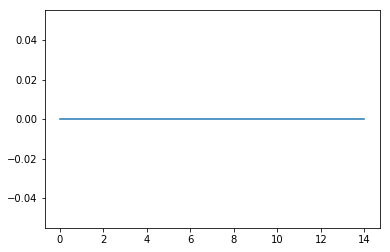

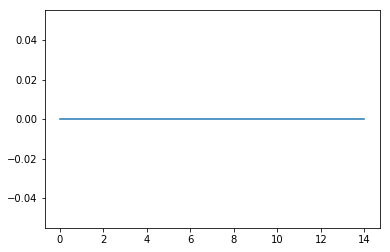

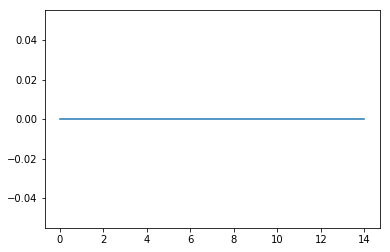

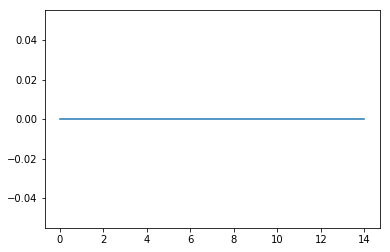

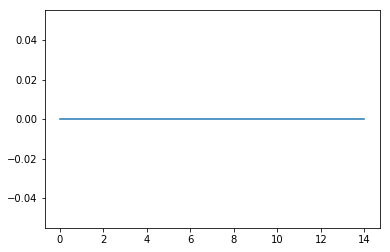

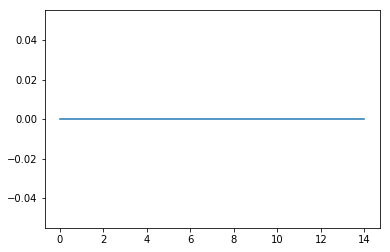

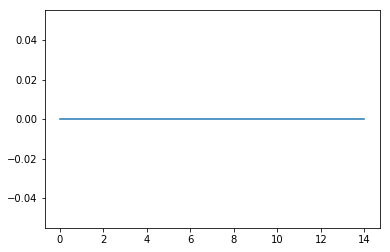

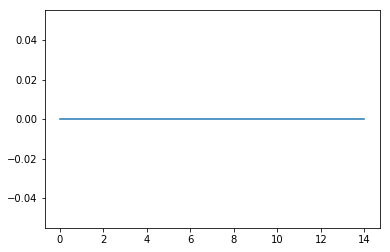

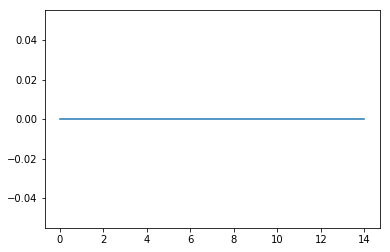

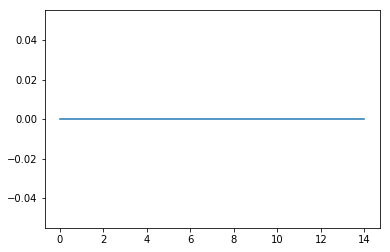

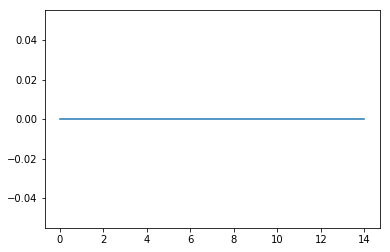

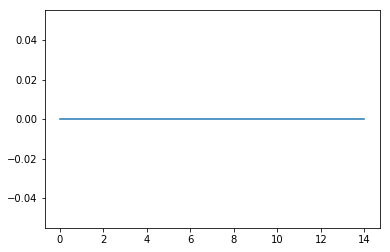

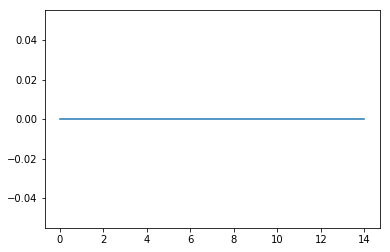

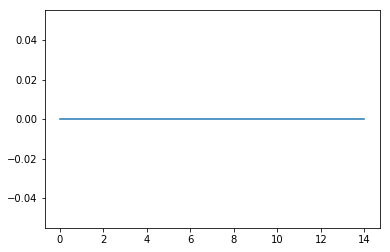

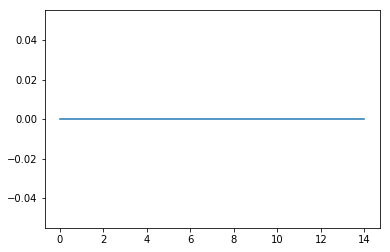

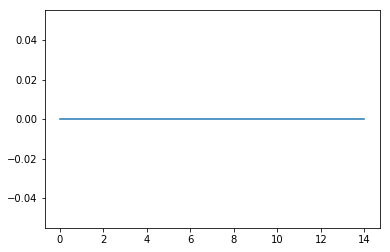

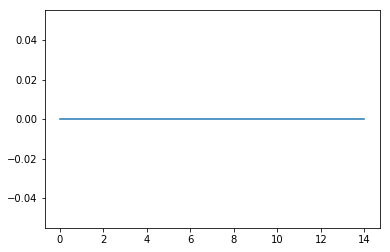

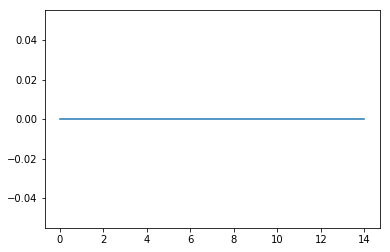

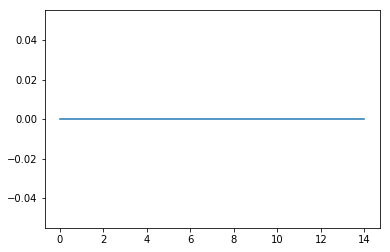

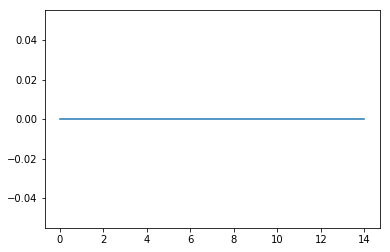

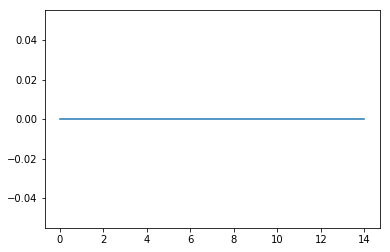

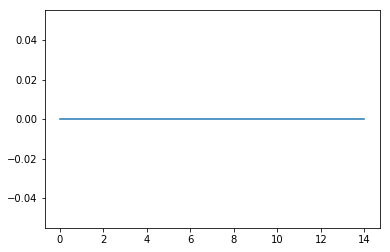

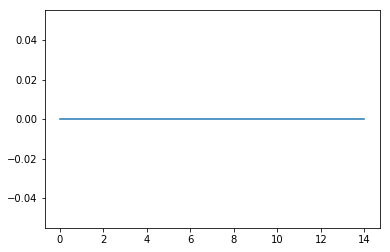

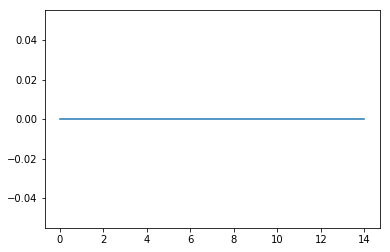

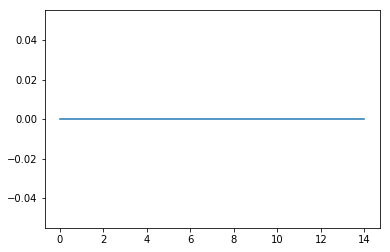

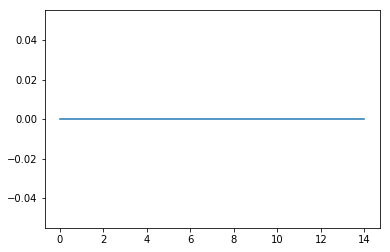

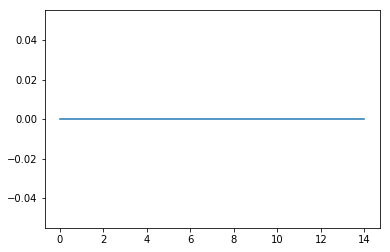

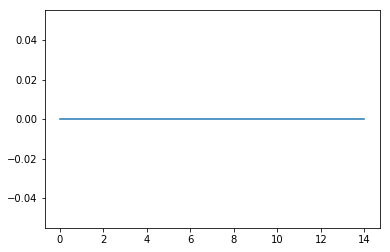

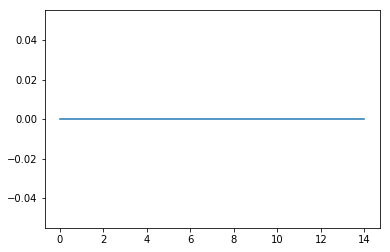

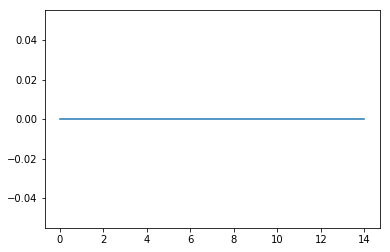

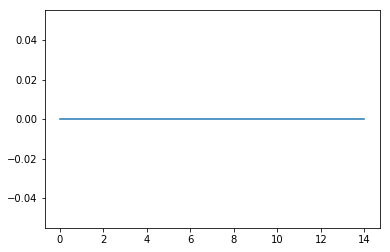

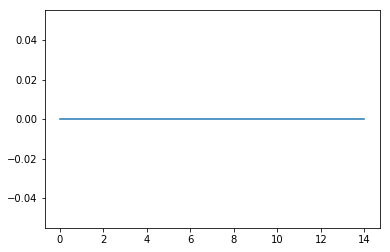

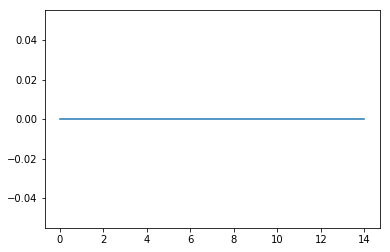

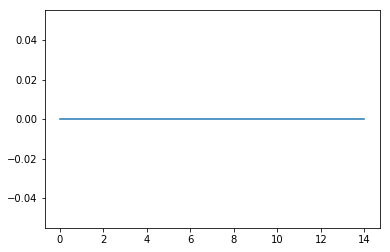

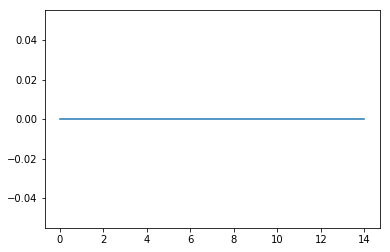

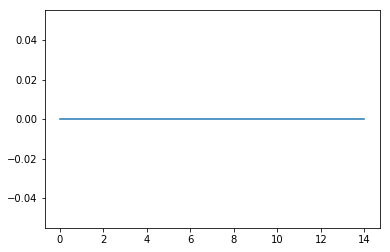

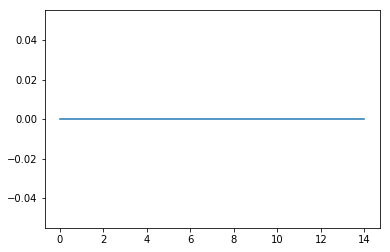

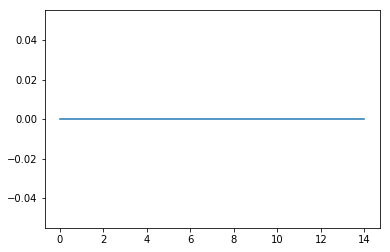

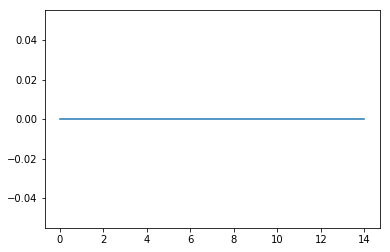

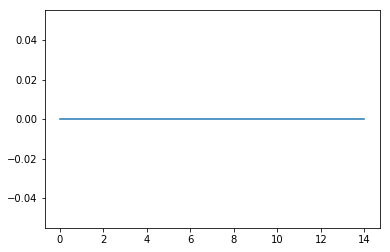

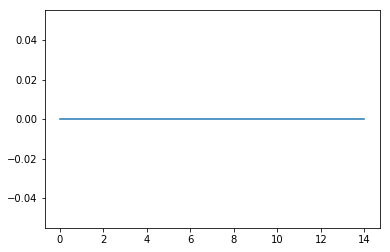

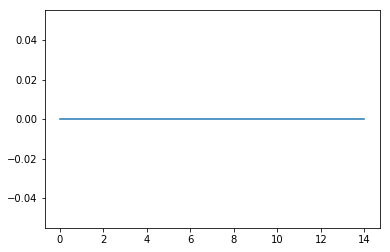

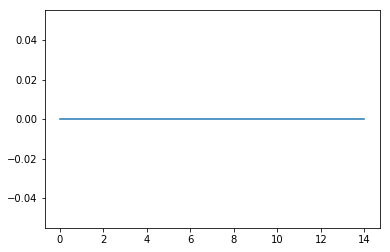

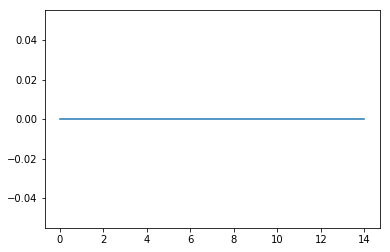

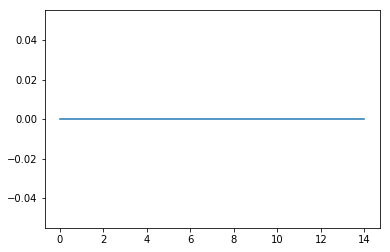

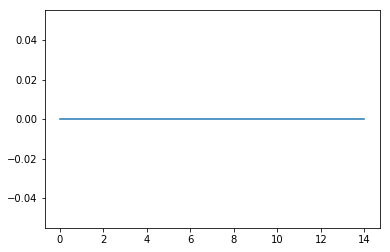

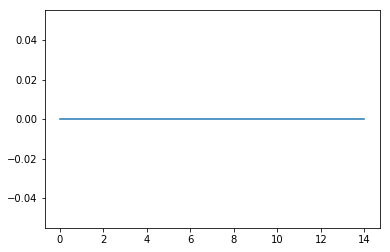

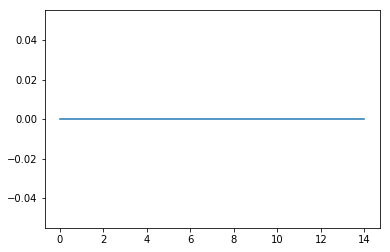

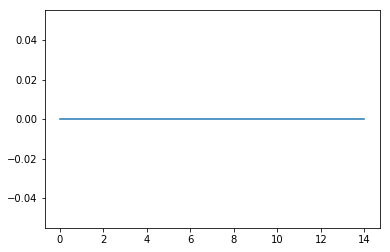

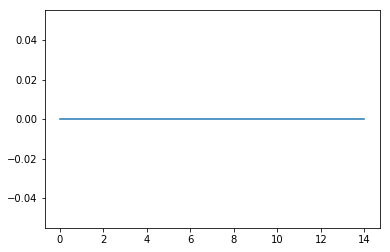

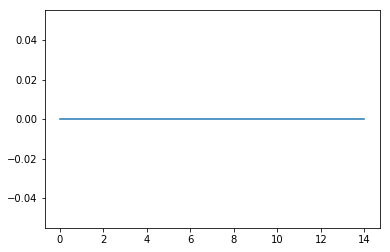

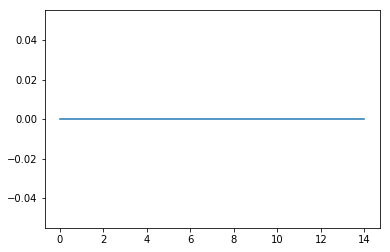

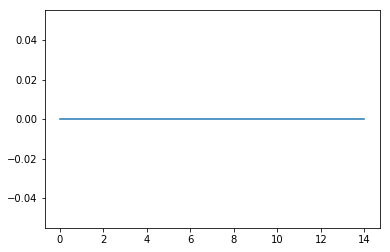

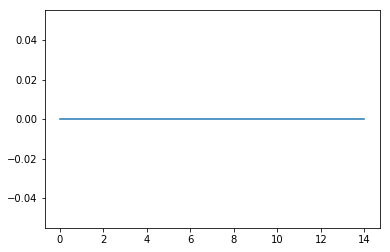

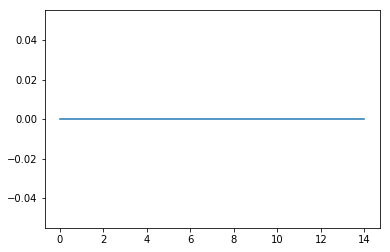

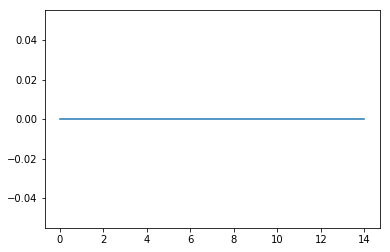

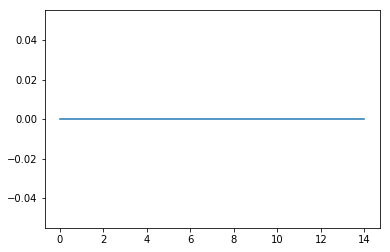

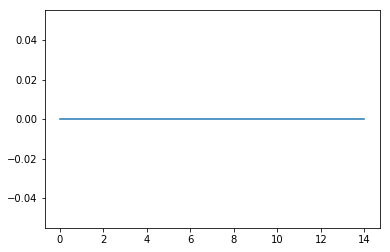

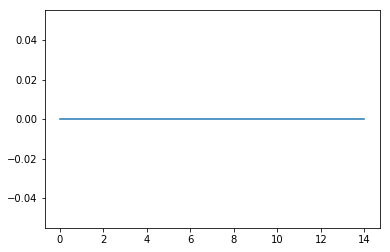

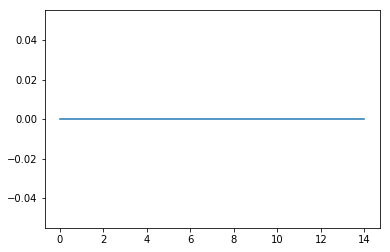

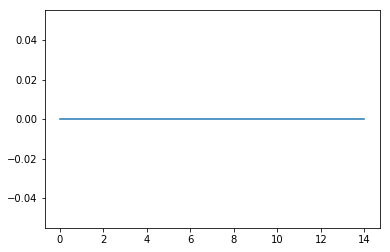

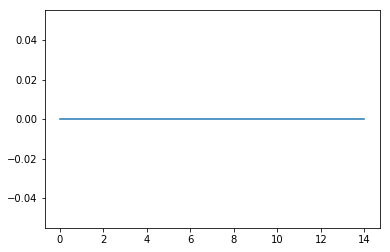

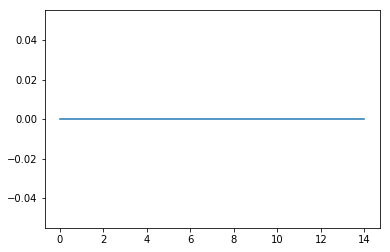

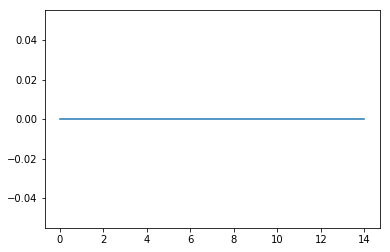

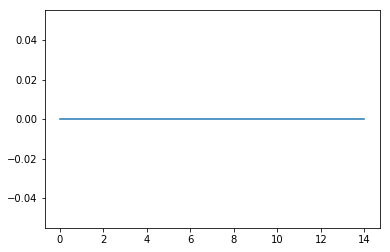

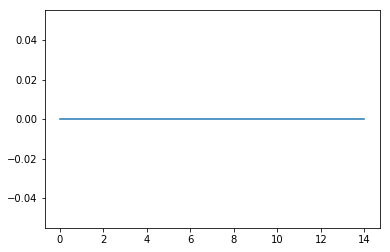

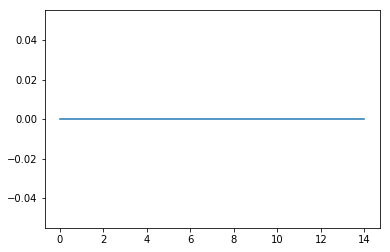

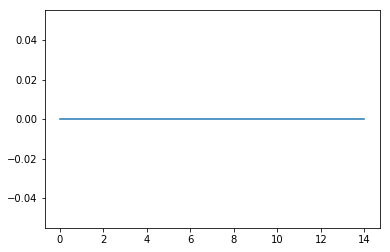

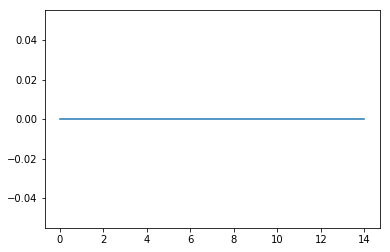

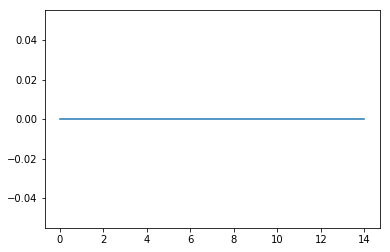

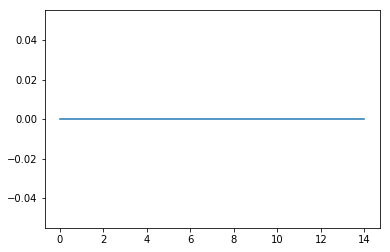

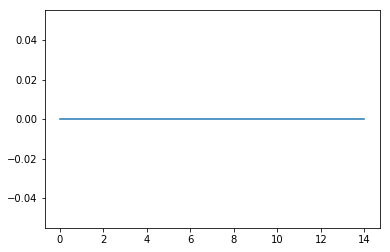

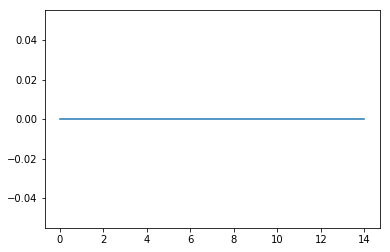

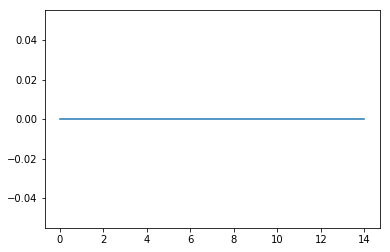

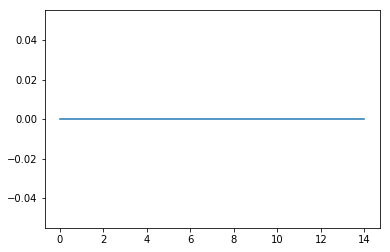

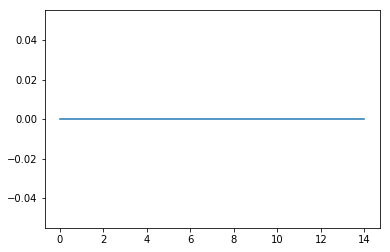

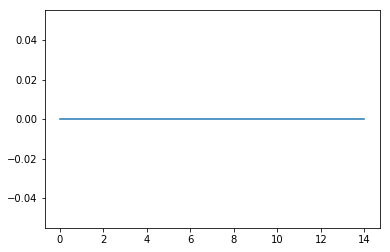

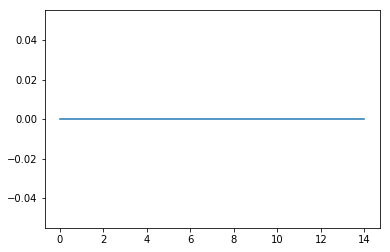

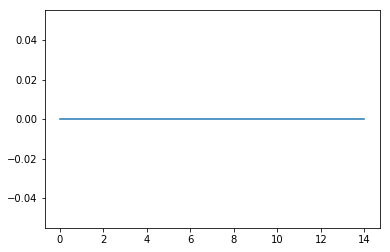

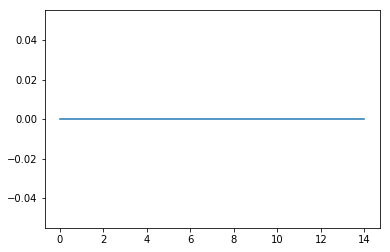

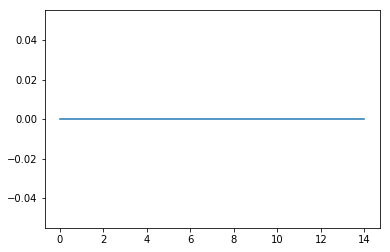

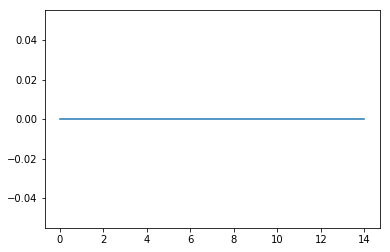

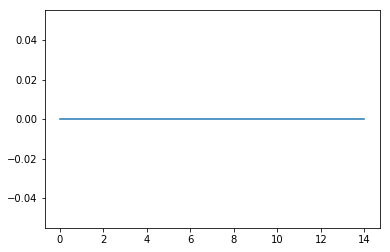

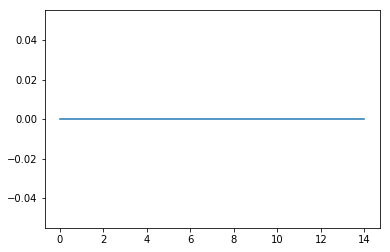

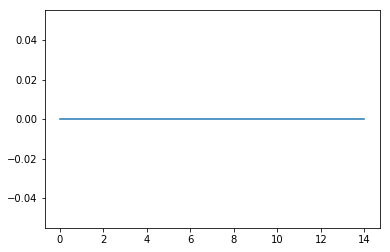

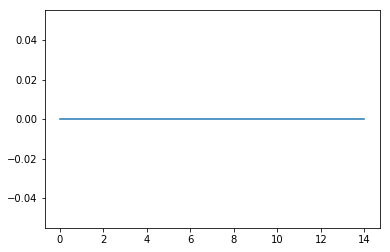

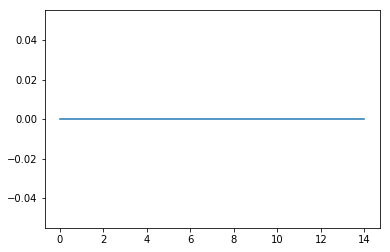

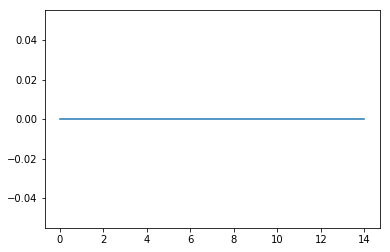

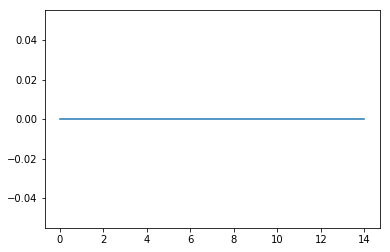

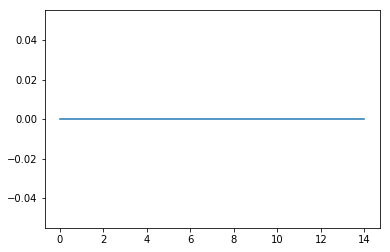

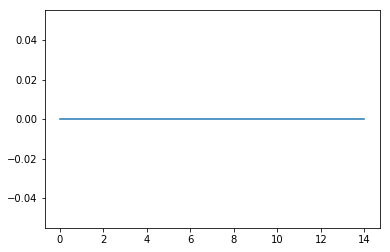

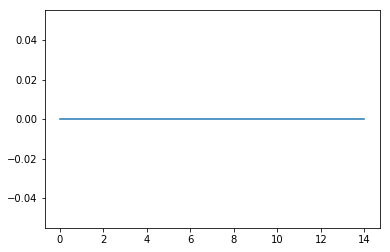

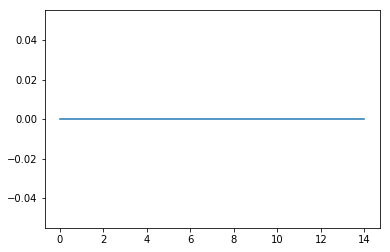

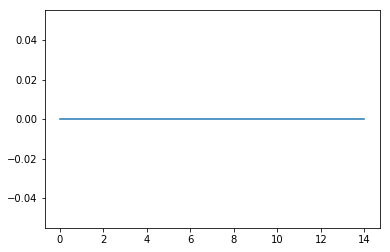

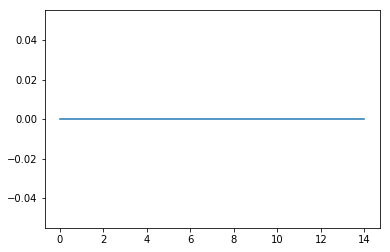

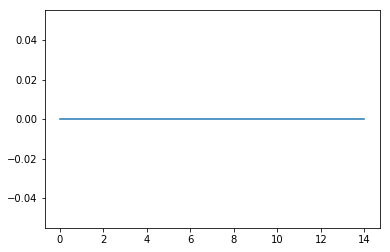

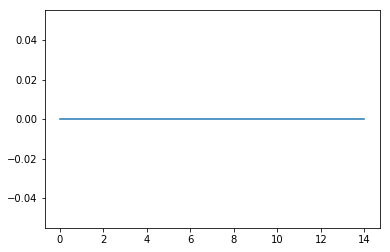

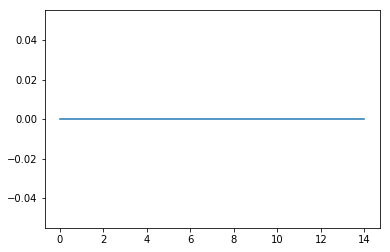

In [44]:
W = W3np
for each_CHin in range(W.shape[1]):
    each_CHout = 0
    # for each_CHout in range(W.shape[2]):
    mplot.figure(each_CHin + each_CHout)
    mplot.plot(W[:, each_CHin, each_CHout])